<a href="https://colab.research.google.com/github/gerritgr/Alia/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AliaMolecule Inference

#### Project Name

In [ ]:
#!pip install wandb --force-reinstall

In [ ]:
PROJECT_NAME = "AliaMoleculeDeskI"
PATH_PATTERN_BASE = "aliamol_paper" #aliamol2 is trained on denoised image
BASELINE = False


DEBUG = False
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


#### Setup

In [ ]:
# Load drive

import os
USE_COLAB = False
try:
  from google.colab import drive
  USE_COLAB = True
except:
  pass

try:
  import wandb # need to do this before chaning cwd
except:
  os.system("pip install wandb")


if USE_COLAB:
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  dir_path = f'/content/drive/MyDrive/colab/{PROJECT_NAME}/'
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
  print("Current Working Directory: ", os.getcwd())
  if os.getcwd() != dir_path:
    os.chdir(dir_path)
    print("New Working Directory: ", os.getcwd())

Mounted at /content/drive
Current Working Directory:  /content
New Working Directory:  /content/drive/MyDrive/colab/AliaMoleculePaperColab5


In [ ]:
# Install packages

import os
import torch
torch_version = torch.__version__.split("+")
#os.environ["TORCH"] = torch_version[0]
#os.environ["CUDA"] = torch_version[1]
try:
  import torch_geometric
except:
  os.system("pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html")
  os.system("pip install torch-geometric")

try:
  import rdkit
except:
  os.system("pip install rdkit")

PATH_PATTERN = PATH_PATTERN_BASE

#### Imports

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
#import imageio # to generate .gifs
import networkx as nx

# always good to have
import glob, random, os, traceback, time, copy
import pickle
import numpy as np
import networkx as nx
import math
from tqdm import tqdm
import gzip

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import Linear as Lin
from torch.nn import Sequential as Seq
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, GraphNorm, BatchNorm
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
from torch_geometric.nn import global_mean_pool, global_add_pool

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')

### Load External

In [ ]:
if not os.path.exists("smiles_to_pyg"):
  os.system("git clone https://github.com/gerritgr/Alia.git && cp -R Alia/* .")
from smiles_to_pyg.molecule_load_and_convert import *

#### Hyperparams

In [ ]:
##
## Diffusion
##
TIMESTEPS = 1000
START = 0.0001
END = 0.015

# Training
BATCH_SIZE = 128*2
GAMMA = 0.1

##
## Pred
##
LEARNING_RATE_GEN = 0.001
EPOCHS_GEN = 100

### PNA Pred
DROPOUT_PRED = 0.05
DEPTH_PRED = 4
HIDDEN_CHANNELS_PRED = 32
TOWERS_PRED = 1
NORMALIZATION_PRED = True

##
## Disc
##
EPOCHS_DISC_MODEL = 70
DISC_NOISE=0.3

### PNA Disc
HIDDEN_CHANNELS_DISC = 8
DEPTH_DISC = 4
DROPOUT_DISC = 0.05
NORMALIZATION_DISC = True


##
## Molecule Encoding
##

INDICATOR_FEATURE_DIM = 1
FEATURE_DIM = 5 # (has to be the same for atom and bond)
ATOM_FEATURE_DIM = FEATURE_DIM
BOND_FEATURE_DIM = FEATURE_DIM
NON_NODES = [True] + [False]*5 + [True] * 5
NON_EDGES = [True] + [True]*5 + [False] * 5

TIME_FEATURE_DIM = 1

# Utils

In [ ]:
def log(d):
  try:
    import wandb
    wandb.log(d)
  except:
    print(d)

In [ ]:
def load_file(filepath):
  print("try to read ", filepath)
  try:
    with gzip.open(filepath, 'rb') as f:
      return pickle.load(f)
  except Exception as e:
      print(f"An error occurred: {str(e)}")
      raise

def write_file(filepath, data):
  try:
    data = data.cpu()
  except:
    pass
  print("try to write ", filepath)
  with gzip.open(filepath, 'wb') as f:
    pickle.dump(data, f)

In [ ]:

def build_dataset(seed=1234):
  try:
    dataset_train, dataset_test = load_file('dataset.pickle')
    if DEBUG:
      return dataset_train[:len(dataset_train)//10], dataset_test[:len(dataset_test)//10]
    return dataset_train, dataset_test
  except Exception as e:
    print(f"Could not load dataset due to error: {str(e)}, generate it now")

  dataset = read_qm9()
  dataset_all = [g for g in dataset if g.x.shape[0] > 1]
  dataset = list()
  for g in tqdm(dataset_all):
    try:
      assert "None" not in str(pyg_to_smiles(g))
      dataset.append(g)
    except:
      pass
  print("Built and clean dataset, length is ", len(dataset), "old length was", len(dataset_all))
  random.Random(seed).shuffle(dataset)
  split = int(len(dataset)*0.8 + 0.5)
  dataset_train = dataset[:split]
  dataset_test = dataset[split:]
  assert(dataset_train[0].x[0,:].numel() == INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM)

  write_file("dataset.pickle", (dataset_train, dataset_test))
  return dataset_train, dataset_test


In [ ]:
def generate_schedule(start = START, end = END, timesteps=TIMESTEPS):
  """
  Generates a schedule of beta and alpha values for a forward process.

  Args:
  start (float): The starting value for the beta values. Default is START.
  end (float): The ending value for the beta values. Default is END.
  timesteps (int): The number of timesteps to generate. Default is TIMESTEPS.

  Returns:
  tuple: A tuple of three tensors containing the beta values, alpha values, and
  cumulative alpha values (alpha bars).
  """
  betas = torch.linspace(start, end, timesteps, device = DEVICE)
  #alphas = 1.0 - betas
  #alpha_bars = torch.cumprod(alphas, axis=0)
  assert(betas.numel() == TIMESTEPS)
  return betas

In [ ]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

def visualize_smiles_from_file(filepath):
    # Read SMILES from file
    with open(filepath, 'r') as file:
        smiles_list = [line.strip() for line in file.readlines()]

    # Convert SMILES to RDKit Mol objects, filtering out invalid ones
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list[:100]]
    mols = [mol for mol in mols if mol is not None]

    # Determine grid size
    num_mols = len(mols)
    cols = 10
    rows = min(10, -(-num_mols // cols))  # ceil division

    # Create a subplot grid
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20),
                            gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

    for i in range(rows):
        for j in range(cols):
            ax = axs[i, j]
            ax.axis("off")  # hide axis
            idx = i * cols + j  # index in mols list
            if idx < num_mols:
                img = Draw.MolToImage(mols[idx], size=(200, 200))
                ax.imshow(img)
            else:
                break

    # Save the figure
    plt.savefig(filepath + '.jpg', format='jpg', bbox_inches='tight')
    plt.close(fig)  # Close the figure after saving to free up memory
    try:
        time.sleep(0.01)
        wandb.log_artifact(filepath + '.jpg', name=f"jpg_{SWEEP_ID}_{filepath.replace('.','')}", type="smiles_grid_graph")
    except Exception as e:
        print(e)
        pass

# Example usage:
# Replace YOUR_FILE_PATH with the path to your SMILES file.
# visualize_smiles_from_file(YOUR_FILE_PATH)


# Base Model

In [ ]:
from torch_geometric.nn import PNA
from torch_geometric.utils import degree


def dataset_to_degree_bin(train_dataset):
  try:
    deg = load_file('deg.pickle')
    deg = deg.to(DEVICE)
    return deg
  except Exception as e:
    print(f"Could not find degree bin due to error: {str(e)}, generate it now")
  assert(train_dataset is not None)


  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

  deg = torch.zeros(max_degree + 1, dtype=torch.long, device=DEVICE)
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

  write_file("deg.pickle", deg.cpu())
  return deg





class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=HIDDEN_CHANNELS_PRED, depth=DEPTH_PRED, dropout=DROPOUT_PRED, towers=TOWERS_PRED, normalization=NORMALIZATION_PRED, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1) #tod fix
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM+ TIME_FEATURE_DIM #INDICATOR_FEATURE_DIM entries are noise free
    out_channels = FEATURE_DIM

    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, out_channels))


  def forward(self, x_in, t, edge_index):
    row_num = x_in.shape[0]
    t = t.view(-1,TIME_FEATURE_DIM)
    x = torch.concat((x_in, t), dim=1)
    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)
    assert(x.numel() > 1 )
    assert(x.shape[0] == row_num)

    #node_indicator = x_in[:,0] > 0
    #node_indicator = x_in[:,0] < 0
    #x[node_indicator, NON_NODES] = x_in[node_indicator, NON_NODES]
    #x[edge_indicator, NON_EDGES] = x_in[edge_indicator, NON_EDGES]

    return x


#model = PNAnet([data])

#model(data.x, data.edge_index, torch.ones(data.x.shape[0]))

In [ ]:
#path_pattern = "aliamol_model_epoch_*.pth"
#sorted(glob.glob(path_pattern))

In [ ]:
def load_latest_checkpoint(model, optimizer, loss_list, epoch_i, path_pattern=None):
  if path_pattern is None:
    path_pattern = PATH_PATTERN + "_model_epoch_*.pth"
  try:
    checkpoint_paths = sorted(glob.glob(path_pattern))
    if len(checkpoint_paths) == 0:
      return model, optimizer, loss_list, epoch_i

    latest_checkpoint_path = checkpoint_paths[-1]
    checkpoint = torch.load(latest_checkpoint_path, map_location=DEVICE)

    # Assuming model and optim are your initialized model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_i = checkpoint['epoch']
    loss_list = checkpoint['loss_list']
    print(f"read checkpoint of epoch {epoch_i:08} from disc.")
  except:
    pass

  return model, optimizer, loss_list, epoch_i

def save_model(model, optimizer, loss_list, epoch_i, upload=False):
  if epoch_i == 0:
    return
  save_path = f"{PATH_PATTERN}_model_epoch_{epoch_i:08}.pth"

  # Save the model state dict and the optimizer state dict in a dictionary
  torch.save({
              'epoch': epoch_i,
              'loss_list': loss_list,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, save_path)
  if upload:
    try:
      wandb.log_artifact(save_path, name=f"src_txt_{SWEEP_ID}_{epoch_i:08}_weightfile", type="weight")
    except Exception as e:
      print(e)
      pass


In [ ]:
def load_base_model(dataset_train, path_pattern=None):
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)
  loss_list = None
  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE_GEN)
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0, path_pattern=path_pattern)

  return model_base

# Inference

In [ ]:
def denoise_one_step_wild(model, g, i):
  betas = generate_schedule()
  t = TIMESTEPS - i - 1 # i=0 is full noise
  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
  row_num = g.x.shape[0]

  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)
  future_t = torch.tensor([float(t)] * g.x.shape[0], device=DEVICE).view(-1,1)

  denoised_x = g.x.clone()
  original_pred = model(g.x, future_t, g.edge_index)

  #noise_pred = noise_pred.view(row_num, -1)
  #x_with_noise = g.x[mask].view(row_num, -1)
  #assert(noise_pred.shape == x_with_noise.shape)
  #future_t = torch.tensor([int(t)] * g.x.shape[0], device=DEVICE).view(-1)
  #original_pred = get_pred_from_noise(noise_pred, x_with_noise, future_t)

  if t-1>0:
    x_with_noise_again, _ = forward_diffusion(original_pred, t-1)
    denoised_x[mask] = x_with_noise_again.flatten()
  else:
    denoised_x[mask] = original_pred.flatten()
  return denoised_x



  #x_in = g.x[mask].flatten()
  #original_pred = get_pred_from_noise(noise_pred, x_in, future_t)
  ##original_pred = (x_in - torch.sqrt(1. - alphas_cumprod_t) * noise_pred)/torch.sqrt(alphas_cumprod_t)
  #assert(original_pred.shape[0] = x_in.shape[0])
  #x = g.x.clone()
  #x[mask] = original_pred
  #if t-1 <= 0:
  #  return x
  #x_with_noise_again, _ = forward_diffusion(x, t-1)
  #denoised_x[mask] = x_with_noise_again[mask]
  #return denoised_x


In [ ]:
def denoise_one_step(model, g, i):
  row_num = g.x.shape[0]

  betas = generate_schedule()
  t = TIMESTEPS - i - 1 # i=0 is full noise
  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)


  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)

  future_t = torch.tensor([float(t)] * g.x.shape[0], device=DEVICE).view(-1,1)

  original_pred = model(g.x, future_t, g.edge_index)

  x_with_noise = g.x[mask].view(row_num, -1)
  future_t = torch.tensor([int(t)] * g.x.shape[0], device=DEVICE).view(-1)
  noise_pred = get_noise_from_pred(original_pred, x_with_noise, future_t)

  values_now = g.x[mask].view(row_num, -1)
  values_endpoint = noise_pred.view(row_num, -1)#[mask] network only prdicts noise

  assert(values_now.shape == values_endpoint.shape)

  # now compute values_one_step_denoised
  model_mean = sqrt_recip_alphas_t * (values_now - beta_t * values_endpoint / sqrt_one_minus_alphas_cumprod_t)
  values_one_step_denoised = model_mean # if t == 0
  if t != 0:
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # in the paper this is in 3.2. note that sigma^2 is variance, not std
    posterior_std_t = torch.sqrt(posterior_variance[t])
    noise = torch.randn_like(values_now, device = DEVICE)
    values_one_step_denoised = model_mean + posterior_std_t * noise

  denoised_x = g.x.clone()
  denoised_x[mask] = values_one_step_denoised.flatten()
  return denoised_x


In [ ]:
def overwrite_with_noise(g):
  g.x_old = g.x.clone()
  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)
  g.x[mask] = torch.randn_like(g.x[mask])
  return g


In [ ]:
@torch.inference_mode()
def generate_examples(model, dataset_train, num=100,wild=False):
  # Setup
  print("generate samples batched")
  model.eval()
  dataset_train_start = list()
  while len(dataset_train_start) < num:
    g = dataset_train[random.sample(range(len(dataset_train)),1)[0]]
    dataset_train_start.append(g.clone().to(DEVICE))
    g = dataset_train_start[-1]
  assert(len(dataset_train_start) == num)
  dataloader = DataLoader(dataset_train_start, batch_size = num)

  # Inference
  for g in dataloader:
    g = g.to(DEVICE)
    print("load g", g, g.batch)
    g = overwrite_with_noise(g)
    for i in tqdm(range(TIMESTEPS)):
      t = int(TIMESTEPS-i-1)
      if wild:
        x_with_less_noise = denoise_one_step_wild(model, g, i)
      else:
        x_with_less_noise = denoise_one_step(model, g, i)
      g.x = x_with_less_noise

    graph_list = g.to_data_list()
    graph_list = [g.cpu() for g in graph_list]

    print("generated graphs ", graph_list[:10])
    return graph_list


#### Frac Correct

In [ ]:
def find_frac_correct(graphs):
  correct = 0
  smiles_list = list()
  for i, g in tqdm(list(enumerate(graphs))):
    smiles = pyg_to_smiles(g)
    if smiles is not None and '.' not in smiles:
      mol = Chem.MolFromSmiles(smiles)
      if mol is not None:
        correct += 1
        smiles_list.append((smiles, i))

  frac_correct = correct/len(graphs)
  unique_frac = len(list(set(smiles_list)))/len(graphs)
  return frac_correct, smiles_list, unique_frac

### Gen many graphs

In [ ]:
#!ls aliamol2*

In [ ]:
def gen_graphs(num_per_generation=1000, num_generations=40, wild=False, path_pattern=None):
  if DEBUG:
    num_generations = int(num_generations/10)
  if path_pattern is None:
    path_pattern = PATH_PATTERN+"_model_epoch_*.pth" #"aliamol_model_epoch_*.pth"
  path = sorted(glob.glob(path_pattern))[-1]
  num_samples = num_per_generation*num_generations
  filepath = path.replace(".pth", f'_{num_samples:06d}_w{wild}_generated.pickle')

  results = list()
  try:
    results = load_file(filepath)
  except:
    pass

  if len(results) == num_per_generation*num_generations:
    return results

  dataset_base, dataset_base_test = build_dataset()
  scatter_list = list()
  model_base = load_base_model(dataset_base, path_pattern = path)

  i = 0
  while len(results) < num_samples:
    i += 1
    num = max(num_per_generation, len(results) - num_samples)
    graphs = generate_examples(model_base, dataset_base, num=num, wild=wild)
    results = results + graphs
    if i % 5 == 0 or len(results) >= num_samples:
      write_file(filepath, results)

  assert(len(results) == num_per_generation*num_generations)
  return results



def test_graph_generation(path_pattern=None, wild=False):
  generated_graphs = gen_graphs(wild=wild, path_pattern=path_pattern)
  return find_frac_correct(generated_graphs) #0.54 #0.02

In [ ]:
#test_graph_generation(path_pattern="aliamol_model_epoch_00003901.pth")

# Discriminator

In [ ]:
from torch_geometric.nn import PNA


class PNAdisc(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=HIDDEN_CHANNELS_DISC, depth=DEPTH_DISC, dropout=DROPOUT_DISC, towers=1, normalization=NORMALIZATION_DISC, pre_post_layers=1):
    super(PNAdisc, self).__init__()
    self.sigmoid = nn.Sigmoid()

    hidden_channels = towers * ((hidden_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM
    assert in_channels == 11
    deg = dataset_to_degree_bin(train_dataset)
    deg = deg.to(DEVICE)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)
    #self.pnanet = PNA(in_channels=11, hidden_channels=hidden_channels, out_channels=1, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg)

    #self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(),Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x, edge_index, batch=None):
    #print("before: x.shape",x.shape, "edge_index.shape",edge_index.shape)
    x = x + torch.randn_like(x)*DISC_NOISE
    x = self.pnanet(x, edge_index)
    #print("after: x.shape",x.shape, "edge_index.shape",edge_index.shape)
    x = global_mean_pool(x, batch)
    #x = torch.sum(x)
    x = self.sigmoid(x)

    return x

In [ ]:
def train_epoch_disc(model_disc, dataloader, optimizer):
  model_disc.train()
  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for batch in dataloader:
    batch = batch.to(DEVICE)
    optimizer.zero_grad()
    #print("batch.x, batch.edge_index, batch.batch", batch, batch.x, batch.edge_index, batch.batch)
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    #print("pred ",pred, "y ", batch.y)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    loss.backward()
    optimizer.step()

    acc = (torch.abs(pred.flatten()-batch.y.flatten()) < 0.5).float()
    acc_list = acc_list + acc.detach().cpu().tolist()
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [ ]:
def test_disc(model_disc, dataloader):
  model_disc.eval()
  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for batch in dataloader:
    batch = batch.to(DEVICE)
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    acc = (torch.abs(pred.flatten()-batch.y.flatten()) < 0.5).float()
    acc_list = acc_list + acc.detach().cpu().tolist()
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [ ]:
def train_disc_model(dataloader_disc, dataloader_disc_test, round_i):
  model_disc = PNAdisc(dataloader_disc)
  model_disc = model_disc.to(DEVICE)
  weight_path = f"discriminator_model_{round_i:05}.pth"

  try:
    checkpoint = torch.load(weight_path)
    model_disc.load_state_dict(checkpoint['model_state_dict'])
    print(f"found disc model in round {round_i:05}")
    return model_disc
  except:
    pass

  epochs = list()
  losses_train = list()
  losses_test = list()

  optimizer_disc = Adam(model_disc.parameters(), lr = 0.0001)
  for epoch_i in range(EPOCHS_DISC_MODEL):
    loss_train, acc_train, t_train = train_epoch_disc(model_disc, dataloader_disc, optimizer_disc)
    if epoch_i % 10 == 1 or epoch_i == EPOCHS_DISC_MODEL-1:
      loss_test, acc_test, t_test = test_disc(model_disc, dataloader_disc_test)
      #print(loss_train,loss_test,acc_train,acc_test,t_train)
      print(f"train discriminator: epoch: {epoch_i:05}, loss: {loss_train:02.4f}, loss test: {loss_test:02.4f}, acc: {acc_train:01.3f}, acc test: {acc_test:01.3f}, time: {t_train:01.3f}")
      log({"disc/step": epoch_i, "disc/epoch": epoch_i, "disc/loss_train": loss_train, 'disc/loss_test': loss_test, "disc/acc_trian": acc_train, "disc/acc_trian": acc_test, "disc/time": t_train})
      epochs.append(epoch_i)
      losses_train.append(loss_train)
      losses_test.append(loss_test)
      plt.clf()
      plt.plot(epochs, losses_train, label='train')
      plt.plot(epochs, losses_test, label='test')
      plt.legend()
      plt.savefig(f"discriminator_model_{round_i:05}.png")

  torch.save({'model_state_dict': model_disc.state_dict(), 'epochs': epochs, "losses_train": losses_train, "losses_test": losses_test}, weight_path)
  return model_disc


In [ ]:
def run_disc(round_i=1):
  fake_graphs = gen_graphs(wild=False)
  dataset_base, dataset_base_test = build_dataset()
  real_graphs = random.sample(dataset_base, len(fake_graphs))
  dataset = list()

  for g in fake_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(0.0)
    dataset.append(g_i)

  for g in real_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(1.0)
    dataset.append(g_i)

  random.shuffle(dataset)
  cut_off = int(len(dataset) * 0.8)
  dataloader_train = DataLoader(dataset[:cut_off], batch_size = BATCH_SIZE, shuffle=True)
  dataloader_test = DataLoader(dataset[cut_off:], batch_size = BATCH_SIZE, shuffle=True)

  model_disc = train_disc_model(dataloader_train, dataloader_test, round_i)
  return model_disc


In [ ]:
#model_disc = run_disc() #0000390 is the last good one

# Forward Diffusion

In [ ]:
def forward_diffusion(node_features, future_t):
  """
  Performs a forward diffusion process on an node_features tensor.
  Each row can theoreetically have its own future time point.
  Implements the second equation from https://youtu.be/a4Yfz2FxXiY?t=649
  """
  row_num = node_features.shape[0]

  if "class 'int'" in str(type(future_t)) or "class 'float'" in str(type(future_t)):
    future_t = torch.tensor([int(future_t)] * row_num).to(DEVICE)

  feature_dim = node_features.shape[1]
  future_t = future_t.view(-1)
  assert(row_num == future_t.numel())
  assert(future_t[0] == future_t[1]) #lets assume the belong to the same graph

  betas = generate_schedule()

  noise = torch.randn_like(node_features, device=DEVICE)
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)
  assert(alphabar_t.numel() == row_num)

  new_node_features_mean = torch.sqrt(alphabar_t) * node_features # column-wise multiplication, now matrix #todo but we want row wise #.view(row_num,1)
  assert(new_node_features_mean.shape == node_features.shape)
  new_node_features_std = torch.sqrt(1.-alphabar_t) #this is a col vector
  new_node_features_std = new_node_features_std.repeat(1,feature_dim) #this is a matrix
  assert(new_node_features_mean.shape == new_node_features_std.shape)
  noisey_node_features =  new_node_features_mean + new_node_features_std * noise

  return noisey_node_features, noise

forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([0,0,999], device=DEVICE)), print(""), forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([999,999,999], device=DEVICE))

((tensor([[1.0018],
          [2.0140],
          [1.3912]], device='cuda:0'),
  tensor([[0.1831],
          [1.4092],
          [1.3241]], device='cuda:0')),
 None,
 (tensor([[-1.3671],
          [-0.0480],
          [ 1.1922]], device='cuda:0'),
  tensor([[-1.3899],
          [-0.0931],
          [ 1.1250]], device='cuda:0')))

# Train Jointly

In [ ]:
def get_pred_from_noise(noise_pred, x_with_noise, future_t):

  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(1.0-alphabar_t)
  x_without_noise = x_with_noise - scaled_noise*noise_pred
  x_without_noise = x_without_noise/torch.sqrt(alphabar_t)
  return x_without_noise


def get_noise_from_pred(original_pred, x_with_noise, future_t):

  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(alphabar_t)
  noise = x_with_noise - scaled_noise*original_pred
  noise = noise / torch.sqrt(1.0-alphabar_t)

  return noise

In [ ]:
def train_epoch(model, dataloader, optimizer, model_disc=None):
  schedule = generate_schedule()
  model.train()
  start_time = time.time()
  loss_list = list()
  loss_list_start = list()
  loss_row = nn.MSELoss(reduction='none')

  for batch in tqdm(dataloader): #todo batches deactivated
    if batch.x.shape[0] < 2:
      continue
    optimizer.zero_grad()
    batch.to(DEVICE)
    row_num = batch.x.shape[0]

    num_graphs_in_batch = int(torch.max(batch.batch).item()+1)
    future_t_select = torch.randint(0, TIMESTEPS, (num_graphs_in_batch,), device = DEVICE)
    future_t = torch.gather(future_t_select, 0, batch.batch)
    assert(future_t.numel() == row_num)

    mask = torch.concat((torch.tensor([False]*row_num, device=DEVICE).view(-1,1), batch.x[:,1:]>-0.5), dim=1) #this only works on original values
    x_start_gt = batch.x[mask].view(row_num, FEATURE_DIM)
    x_with_noise, noise_gt = forward_diffusion(x_start_gt, future_t)

    x_in = batch.x.clone()
    x_in[mask] = x_with_noise.flatten()
    x_start_pred = model(x_in, future_t, batch.edge_index)
    loss = F.mse_loss(x_start_gt, x_start_pred)


    #row_num = x_in.shape[0]
    #assert(x_with_noise.shape[0] == row_num)
   # assert(noise_pred.shape[0] == row_num)
    #assert(noise_pred.shape == x_with_noise.shape)
    #assert(noise_pred.shape == noise_gt.shape)
    #assert(noise_pred.shape == x_start_gt.shape)
    #x_start_pred = get_pred_from_noise(noise_pred, x_with_noise, future_t)

    #assert(F.mse_loss(get_pred_from_noise(noise_gt, x_with_noise, future_t), x_start_gt) < 0.00001)

    #loss = F.mse_loss(noise_gt, noise_pred)
    #loss_start = F.mse_loss(x_start_gt, x_start_pred)  #multiply with torch.sqrt(1.0-alphabar_t)  #F.mse_loss(x_start_gt, x_start_pred)  # torch.sum(F.mse_loss(x_start_gt, x_start_pred, dim=1)/future_t) #torch.sum(torch.sum((x_start_gt- x_start_pred)**2,dim=1) / (1+future_t.view(-1,1)))
    #loss_agg = loss + 0.5*loss_start

    #x_in = batch.x.clone()
    #x_in[mask] = x_start_pred.flatten()
    #disc_loss = torch.abs(1.0- model_disc(x_in, batch.edge_index, batch=batch.batch))
    #disc_loss = torch.mean(disc_loss)
    #loss_agg = loss + 0.25*disc_loss

    disc_loss = torch.tensor(0.0, device=DEVICE)
    if model_disc is not None:
      x_in[mask] = x_start_pred.flatten()
      disc_loss = torch.mean((1.0- model_disc(x_in, batch.edge_index, batch=batch.batch))**2)
      loss = (1.0 - GAMMA) * loss + GAMMA*disc_loss



    loss.backward()
    loss_list.append(loss.item())
    loss_list_start.append(disc_loss.item())
    optimizer.step()


  return np.mean(loss_list),np.mean(loss_list_start), time.time()-start_time

In [ ]:
def log_smiles(smiles, filename):
  try:
    with open(filename, "w") as file:
      for string in smiles:
        file.write(str(string) + "\n")
    wandb.log_artifact(filename, name=f"src_txt_{SWEEP_ID}_{filename}", type="smiles")
    time.sleep(0.01)
    visualize_smiles_from_file(filename)
  except Exception as e:
    print(e)
    pass

In [ ]:
def train_base_model(train_loader, epoch_num=EPOCHS_GEN, model_disc=None):
  print("train base model")
  if DEBUG:
    epoch_num = int(epoch_num/10)

  dataset_train = train_loader.dataset
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)

  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE_GEN*0.01) #ok makes no sense
  loss_list = list()
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0)

  epoch_start = min(epoch_start, epoch_num)
  print("from", epoch_start, "to", epoch_num)


  for epoch_i in range(epoch_start,epoch_num):
    try:
      loss, loss_start, time_elapsed = train_epoch(model_base, train_loader, optimizer, model_disc=model_disc)
      loss_list.append((epoch_i, loss))
      if epoch_i % 1 == 0 or epoch_i == epoch_num - 1 or BATCH_SIZE == 1:
        #plot_list(loss_list, "train_base.png", title="train loss base model", xlabel='epoch', ylabel='loss')
        mean_loss = np.mean([y for x,y in loss_list] + [loss])
        print(f"loss in epoch {epoch_i:07} is: {loss:05.4f} with mean loss {mean_loss:05.4f} with start loss {loss_start:05.4f} with runtime {time_elapsed:05.4f}")
        log({"gen/step": epoch_i, "gen/epoch": epoch_i, "gen/loss": loss, "gen/mean_loss": mean_loss, "gen/start_loss": loss_start, "gen/runtime": time_elapsed})

      if (epoch_i % 20 == 0 and epoch_i > epoch_start) or epoch_i == epoch_num - 1 or BATCH_SIZE == 1:
        #graphs = generate_examples(model_base, epoch_i, betas, dataset_train)
        #graph_loss_list.append(compute_generation_loss(graphs, None))
        #print(f"generation loss: {graph_loss_list[-1]:06.4f}")
        #plot_base(graph_loss_list, loss_list)
        #pass
        print("save")
        save_model(model_base, optimizer, loss_list, epoch_i+1, upload=epoch_i % 100 == 0 and epoch_i>9) #todo really +1?
        time.sleep(0.1)
        frac, smiles_list, unique_frac = test_graph_generation(wild=False)
        frac_wild, smiles_list_wild, unique_frac_wild = test_graph_generation(wild=True)
        print("frac correct graphs: ", frac, "with wild inference", frac_wild)
        log({"inference/step": epoch_i, "inference/epoch": epoch_i, "inference/frac_normal": frac, "inference/frac_wild": frac_wild, "inference/frac_normal_unique": unique_frac, "inference/frac_wild_unique": unique_frac_wild})
        log_smiles(smiles_list, f"{PATH_PATTERN}_smiles_{epoch_i}_normal.txt")
        log_smiles(smiles_list_wild, f"{PATH_PATTERN}_smiles_{epoch_i}_wild.txt")
        try:
          print(smiles_list[:20])
          print(smiles_list_wild[:20])
        except Exception as e:
          print(e)
          pass


    except Exception as e:
      print("An error occurred during training: \n", str(e))
      traceback.print_exc()
      raise e


  return model_base

In [ ]:
def start_experiments(rounds=5):
  global DISC_NOISE
  print("DISC_NOISE", DISC_NOISE)
  dataset_base, dataset_base_test = build_dataset()
  dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)
  model_base = train_base_model(dataloader_base, epoch_num = EPOCHS_GEN*1)

  for round_i in range(1, rounds):
    if BASELINE:
      model_disc = None
    else:
      model_disc = run_disc(round_i=round_i)
    model_base = train_base_model(dataloader_base, epoch_num = EPOCHS_GEN*(round_i+1), model_disc=model_disc)

  save_src_file()
  return  model_base


#0000390 is the last good one


In [ ]:
#!rm aliamol_model_epoch_00004001_010000_generated.pickle aliamol_model_epoch_00004001.pth


### With WandB

In [ ]:
import wandb
print(wandb.__path__)

['/usr/local/lib/python3.10/dist-packages/wandb']


In [ ]:
sweep_config = {
    "name": "AliaMol",
    "method": "random",
    "metric": {
        "name": "ENZYMES/besttest_acc",
        "goal": "maximize",
    },
    "parameters": {
        "BATCH_SIZE": {"values": [128*2]},
        "GAMMA": {"values": [0.1]},
        "DISC_NOISE": {"values": [0.3]},
        "EPOCHS_DISC_MODEL": {"values": [100]},
        "EPOCHS_GEN": {"values": [100]},
    },
}

In [ ]:
def save_src_file():
  os.system("pip list > pip_list.txt 2>&1")
  for txt_file in sorted(glob.glob('*.txt')):
    z = "".join(filter(str.isalnum, txt_file))
    wandb.log_artifact(txt_file, name=f"src_txt_{SWEEP_ID}_{z}", type="my_dataset_txt")
  for python_file in sorted(glob.glob('*.ipynb')):
    z = "".join(filter(str.isalnum, python_file))
    wandb.log_artifact(python_file, name=f"src_ipynb_{SWEEP_ID}_{z}", type="my_dataset_ipynb")
  for python_file in sorted(glob.glob('*.py')):
    z = "".join(filter(str.isalnum, python_file))
    wandb.log_artifact(python_file, name=f"src_py_{SWEEP_ID}_{z}", type="my_dataset_py")




In [ ]:
#! cp ../Insa/api_key.txt api_key.txt

In [ ]:
#os.system('wandb login --relogin --host=https://api.wandb.ai --key='+get_wand_api_key())

In [ ]:
def get_wand_api_key():
  import sys
  IN_COLAB = 'google.colab' in sys.modules
  if not IN_COLAB:
    os.system("cp ~/api_key.txt api_key.txt")
  file_path = 'api_key.txt'
  with open(file_path, 'r') as file:
      api_key = file.read().strip()
  return api_key

#wandb.login(key=get_wand_api_key())

def main():
  global PATH_PATTERN
  with wandb.init() as run:
    run_id = 0
    try:
      run_id = load_file("runs.pickle") + 1
    except:
      pass

    PATH_PATTERN = PATH_PATTERN_BASE + '_' +str(run_id) + '_' +str(BASELINE)
    save_src_file()
    for hyper_param_name in sweep_config['parameters']:
      globals()[hyper_param_name] = run.config[hyper_param_name]
      print("set ", hyper_param_name, "=", run.config[hyper_param_name])
    start_experiments()
    write_file("runs.pickle", run_id)

def start_with_wandb(set_baseline_true=False):
  import wandb
  global SWEEP_ID, USE_WANDB, PATH_PATTERN, BASELINE
  if set_baseline_true:
    BASELINE = True
  else:
    BASELINE = False
  USE_WANDB = True
  os.environ["WANDB_MODE"] = "online"
  try:
    SWEEP_ID = wandb.sweep(sweep_config, project=PROJECT_NAME)
    wandb.agent(SWEEP_ID, function=main, count=5)
  except Exception as e:
    error_message = traceback.format_exc()
    print("final error:\n", error_message)
    with open('_error_log.txt', 'a') as f:
      f.write(error_message + '\n')
    time.sleep(10)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: yyxpv29n
Sweep URL: https://wandb.ai/nextaid/AliaMoleculePaperColab5/sweeps/yyxpv29n


wandb: Agent Starting Run: pto40o2f with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.3
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1
wandb: Currently logged in as: gerritgr (nextaid). Use `wandb login --relogin` to force relogin


try to read  runs.pickle
An error occurred: [Errno 2] No such file or directory: 'runs.pickle'
set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.3
set  EPOCHS_DISC_MODEL = 100
set  EPOCHS_GEN = 100
DISC_NOISE 0.3
try to read  dataset.pickle
train base model
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
from 10 to 10
try to read  aliamol_paper_0_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00001
train base model
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
from 20 to 20
try to read  aliamol_paper_0_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00002
train base model
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
from 30 to 30
try to read  aliamol_paper_0_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.

/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


train discriminator: epoch: 00001, loss: 0.6895, loss test: 0.6884, acc: 0.524, acc test: 0.499, time: 0.964
train discriminator: epoch: 00011, loss: 0.0868, loss test: 0.0780, acc: 0.998, acc test: 1.000, time: 0.965
train discriminator: epoch: 00021, loss: 0.0200, loss test: 0.0198, acc: 1.000, acc test: 1.000, time: 0.985
train discriminator: epoch: 00031, loss: 0.0092, loss test: 0.0079, acc: 1.000, acc test: 1.000, time: 0.965
train discriminator: epoch: 00041, loss: 0.0052, loss test: 0.0036, acc: 1.000, acc test: 1.000, time: 1.002
train discriminator: epoch: 00051, loss: 0.0031, loss test: 0.0023, acc: 1.000, acc test: 1.000, time: 0.974
train discriminator: epoch: 00061, loss: 0.0026, loss test: 0.0018, acc: 1.000, acc test: 1.000, time: 0.985
train discriminator: epoch: 00071, loss: 0.0016, loss test: 0.0011, acc: 1.000, acc test: 1.000, time: 0.958
train discriminator: epoch: 00081, loss: 0.0018, loss test: 0.0010, acc: 1.000, acc test: 1.000, time: 0.956
train discriminator

100%|██████████| 42/42 [00:03<00:00, 11.46it/s]


loss in epoch 0000030 is: 0.1774 with mean loss 0.1781 with start loss 0.9992 with runtime 3.6728


100%|██████████| 42/42 [00:03<00:00, 12.37it/s]


loss in epoch 0000031 is: 0.1774 with mean loss 0.1781 with start loss 0.9992 with runtime 3.4019


100%|██████████| 42/42 [00:03<00:00, 12.58it/s]


loss in epoch 0000032 is: 0.1773 with mean loss 0.1781 with start loss 0.9993 with runtime 3.3436


100%|██████████| 42/42 [00:03<00:00, 12.24it/s]


loss in epoch 0000033 is: 0.1773 with mean loss 0.1781 with start loss 0.9992 with runtime 3.4380


100%|██████████| 42/42 [00:03<00:00, 12.18it/s]


loss in epoch 0000034 is: 0.1772 with mean loss 0.1780 with start loss 0.9991 with runtime 3.4549


100%|██████████| 42/42 [00:03<00:00, 12.50it/s]


loss in epoch 0000035 is: 0.1772 with mean loss 0.1780 with start loss 0.9992 with runtime 3.3671


100%|██████████| 42/42 [00:03<00:00, 12.49it/s]


loss in epoch 0000036 is: 0.1772 with mean loss 0.1780 with start loss 0.9993 with runtime 3.3661


100%|██████████| 42/42 [00:03<00:00, 12.31it/s]


loss in epoch 0000037 is: 0.1771 with mean loss 0.1780 with start loss 0.9992 with runtime 3.4170


100%|██████████| 42/42 [00:03<00:00, 11.89it/s]


loss in epoch 0000038 is: 0.1770 with mean loss 0.1779 with start loss 0.9992 with runtime 3.5373


100%|██████████| 42/42 [00:03<00:00, 12.59it/s]


loss in epoch 0000039 is: 0.1768 with mean loss 0.1779 with start loss 0.9990 with runtime 3.3401
save
try to read  aliamol_paper_0_False_model_epoch_00000040_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_0_False_model_epoch_00000040_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137972], x=[43297, 11], batch=[43297], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.29it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137876], x=[43273, 11], batch=[43273], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137536], x=[43177, 11], batch=[43177], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137624], x=[43199, 11], batch=[43199], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_0_False_model_epoch_00000040_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 260.62it/s]


try to read  aliamol_paper_0_False_model_epoch_00000040_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_0_False_model_epoch_00000040_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137928], x=[43287, 11], batch=[43287], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136824], x=[42972, 11], batch=[42972], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137240], x=[43092, 11], batch=[43092], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.10it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137976], x=[43297, 11], batch=[43297], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_0_False_model_epoch_00000040_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 262.69it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_0_False_model_epoch_00000040_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
train discriminator: epoch: 00001, loss: 0.7154, loss test: 0.7382, acc: 0.500, acc test: 0.499, time: 1.018
train discriminator: epoch: 00011, loss: 0.1486, loss test: 0.1250, acc: 0.999, acc test: 0.999, time: 0.999
train discriminator: epoch: 00021, loss: 0.0358, loss test: 0.0319, acc: 0.999, acc test: 1.000, time: 1.016
train discriminator: epoch: 00031, loss: 0.0146, loss test: 0.0137, acc: 0.999, acc test: 0.999, time: 1.003
train discriminator: epoch: 00041, loss: 0.0082, loss test: 0.0065, acc: 1.000, acc test: 1.000, time: 0.988
train discriminator: epoch: 00051, loss: 0.0053, loss test: 0.0039, acc: 1.000, acc test: 1.000, time: 0.974
train discriminator: epoch: 00061, loss: 0.0037, loss

100%|██████████| 42/42 [00:03<00:00, 12.16it/s]


loss in epoch 0000040 is: 0.1765 with mean loss 0.1779 with start loss 0.9972 with runtime 3.4575


100%|██████████| 42/42 [00:03<00:00, 12.09it/s]


loss in epoch 0000041 is: 0.1763 with mean loss 0.1778 with start loss 0.9972 with runtime 3.4806


100%|██████████| 42/42 [00:03<00:00, 12.20it/s]


loss in epoch 0000042 is: 0.1761 with mean loss 0.1778 with start loss 0.9972 with runtime 3.4499


100%|██████████| 42/42 [00:03<00:00, 11.59it/s]


loss in epoch 0000043 is: 0.1759 with mean loss 0.1777 with start loss 0.9972 with runtime 3.6302


100%|██████████| 42/42 [00:03<00:00, 10.82it/s]


loss in epoch 0000044 is: 0.1754 with mean loss 0.1777 with start loss 0.9971 with runtime 3.8893


100%|██████████| 42/42 [00:04<00:00, 10.40it/s]


loss in epoch 0000045 is: 0.1750 with mean loss 0.1776 with start loss 0.9971 with runtime 4.0434


100%|██████████| 42/42 [00:04<00:00, 10.41it/s]


loss in epoch 0000046 is: 0.1745 with mean loss 0.1775 with start loss 0.9972 with runtime 4.0401


100%|██████████| 42/42 [00:04<00:00, 10.29it/s]


loss in epoch 0000047 is: 0.1743 with mean loss 0.1775 with start loss 0.9966 with runtime 4.0874


100%|██████████| 42/42 [00:04<00:00, 10.19it/s]


loss in epoch 0000048 is: 0.1737 with mean loss 0.1774 with start loss 0.9963 with runtime 4.1288


100%|██████████| 42/42 [00:03<00:00, 10.81it/s]


loss in epoch 0000049 is: 0.1732 with mean loss 0.1773 with start loss 0.9958 with runtime 3.8915
save
try to read  aliamol_paper_0_False_model_epoch_00000050_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_0_False_model_epoch_00000050_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137716], x=[43228, 11], batch=[43228], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138244], x=[43375, 11], batch=[43375], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.66it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136584], x=[42902, 11], batch=[42902], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.33it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137616], x=[43199, 11], batch=[43199], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamol_paper_0_False_model_epoch_00000050_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:16<00:00, 246.40it/s]


try to read  aliamol_paper_0_False_model_epoch_00000050_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_0_False_model_epoch_00000050_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137608], x=[43197, 11], batch=[43197], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138388], x=[43417, 11], batch=[43417], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.35it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138080], x=[43329, 11], batch=[43329], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137592], x=[43192, 11], batch=[43192], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_0_False_model_epoch_00000050_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 253.57it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to write  runs.pickle


disc/acc_trian,▁██████████▁██████████
disc/epoch,▁▂▂▃▄▅▅▆▇▇█▁▂▂▃▄▅▅▆▇▇█
disc/loss_test,█▂▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁
disc/loss_train,█▂▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁
disc/step,▁▂▂▃▄▅▅▆▇▇█▁▂▂▃▄▅▅▆▇▇█
disc/time,▂▂▄▂▆▃▄▁▁▂▇█▆█▆▅▃▅▅▇▅▆
epoch,▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▇▇▇███
frac_normal,▁▁
frac_normal_unique,▁▁
frac_wild,▁▁
frac_wild_unique,▁▁


wandb: Agent Starting Run: mxln8jb6 with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.3
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1


try to read  runs.pickle
set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.3
set  EPOCHS_DISC_MODEL = 100
set  EPOCHS_GEN = 100
DISC_NOISE 0.3
try to read  dataset.pickle
train base model
try to read  deg.pickle
from 0 to 10


100%|██████████| 42/42 [00:02<00:00, 17.11it/s]


loss in epoch 0000000 is: 0.1768 with mean loss 0.1768 with start loss 0.0000 with runtime 2.4596


100%|██████████| 42/42 [00:02<00:00, 17.60it/s]


loss in epoch 0000001 is: 0.1687 with mean loss 0.1714 with start loss 0.0000 with runtime 2.3936


100%|██████████| 42/42 [00:02<00:00, 18.31it/s]


loss in epoch 0000002 is: 0.1593 with mean loss 0.1661 with start loss 0.0000 with runtime 2.2994


100%|██████████| 42/42 [00:02<00:00, 18.29it/s]


loss in epoch 0000003 is: 0.1487 with mean loss 0.1605 with start loss 0.0000 with runtime 2.3030


100%|██████████| 42/42 [00:02<00:00, 18.60it/s]


loss in epoch 0000004 is: 0.1389 with mean loss 0.1552 with start loss 0.0000 with runtime 2.2644


100%|██████████| 42/42 [00:02<00:00, 17.81it/s]


loss in epoch 0000005 is: 0.1282 with mean loss 0.1498 with start loss 0.0000 with runtime 2.3634


100%|██████████| 42/42 [00:02<00:00, 17.37it/s]


loss in epoch 0000006 is: 0.1172 with mean loss 0.1444 with start loss 0.0000 with runtime 2.4240


100%|██████████| 42/42 [00:02<00:00, 18.48it/s]


loss in epoch 0000007 is: 0.1071 with mean loss 0.1391 with start loss 0.0000 with runtime 2.2782


100%|██████████| 42/42 [00:02<00:00, 18.90it/s]


loss in epoch 0000008 is: 0.0992 with mean loss 0.1343 with start loss 0.0000 with runtime 2.2281


100%|██████████| 42/42 [00:02<00:00, 18.41it/s]


loss in epoch 0000009 is: 0.0938 with mean loss 0.1302 with start loss 0.0000 with runtime 2.2859
save
try to read  aliamol_paper_1_False_model_epoch_00000010_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000010_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138124], x=[43342, 11], batch=[43342], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137496], x=[43166, 11], batch=[43166], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.09it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137212], x=[43083, 11], batch=[43083], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138616], x=[43480, 11], batch=[43480], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.85it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000010_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:16<00:00, 235.40it/s]


try to read  aliamol_paper_1_False_model_epoch_00000010_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000010_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137272], x=[43100, 11], batch=[43100], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137712], x=[43224, 11], batch=[43224], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.04it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138372], x=[43413, 11], batch=[43413], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137412], x=[43142, 11], batch=[43142], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000010_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:16<00:00, 245.96it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_1_False_model_epoch_00000010_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00001
train base model
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
from 10 to 20


100%|██████████| 42/42 [00:03<00:00, 11.84it/s]


loss in epoch 0000010 is: 0.1096 with mean loss 0.1298 with start loss 0.2810 with runtime 3.5514


100%|██████████| 42/42 [00:03<00:00, 11.82it/s]


loss in epoch 0000011 is: 0.1074 with mean loss 0.1279 with start loss 0.2759 with runtime 3.5601


100%|██████████| 42/42 [00:03<00:00, 11.92it/s]


loss in epoch 0000012 is: 0.1061 with mean loss 0.1262 with start loss 0.2735 with runtime 3.5287


100%|██████████| 42/42 [00:03<00:00, 12.03it/s]


loss in epoch 0000013 is: 0.1053 with mean loss 0.1248 with start loss 0.2707 with runtime 3.4967


100%|██████████| 42/42 [00:03<00:00, 12.18it/s]


loss in epoch 0000014 is: 0.1048 with mean loss 0.1235 with start loss 0.2679 with runtime 3.4546


100%|██████████| 42/42 [00:03<00:00, 11.93it/s]


loss in epoch 0000015 is: 0.1042 with mean loss 0.1223 with start loss 0.2637 with runtime 3.5271


100%|██████████| 42/42 [00:03<00:00, 12.02it/s]


loss in epoch 0000016 is: 0.1041 with mean loss 0.1213 with start loss 0.2637 with runtime 3.5004


100%|██████████| 42/42 [00:03<00:00, 12.19it/s]


loss in epoch 0000017 is: 0.1039 with mean loss 0.1204 with start loss 0.2623 with runtime 3.4509


100%|██████████| 42/42 [00:03<00:00, 12.10it/s]


loss in epoch 0000018 is: 0.1040 with mean loss 0.1196 with start loss 0.2640 with runtime 3.4745


100%|██████████| 42/42 [00:03<00:00, 11.99it/s]


loss in epoch 0000019 is: 0.1039 with mean loss 0.1188 with start loss 0.2631 with runtime 3.5086
save
try to read  aliamol_paper_1_False_model_epoch_00000020_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000020_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138344], x=[43406, 11], batch=[43406], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137856], x=[43262, 11], batch=[43262], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137336], x=[43119, 11], batch=[43119], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137376], x=[43129, 11], batch=[43129], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000020_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 258.48it/s]


try to read  aliamol_paper_1_False_model_epoch_00000020_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000020_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137308], x=[43111, 11], batch=[43111], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137772], x=[43238, 11], batch=[43238], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138352], x=[43405, 11], batch=[43405], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137996], x=[43306, 11], batch=[43306], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000020_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 256.19it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_1_False_model_epoch_00000020_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00002
train base model
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
from 20 to 30


100%|██████████| 42/42 [00:03<00:00, 11.89it/s]


loss in epoch 0000020 is: 0.1233 with mean loss 0.1199 with start loss 0.4583 with runtime 3.5366


100%|██████████| 42/42 [00:03<00:00, 11.95it/s]


loss in epoch 0000021 is: 0.1228 with mean loss 0.1200 with start loss 0.4548 with runtime 3.5216


100%|██████████| 42/42 [00:03<00:00, 12.05it/s]


loss in epoch 0000022 is: 0.1226 with mean loss 0.1201 with start loss 0.4533 with runtime 3.4935


100%|██████████| 42/42 [00:03<00:00, 12.47it/s]


loss in epoch 0000023 is: 0.1225 with mean loss 0.1202 with start loss 0.4521 with runtime 3.3730


100%|██████████| 42/42 [00:03<00:00, 12.42it/s]


loss in epoch 0000024 is: 0.1224 with mean loss 0.1203 with start loss 0.4514 with runtime 3.3863


100%|██████████| 42/42 [00:03<00:00, 11.87it/s]


loss in epoch 0000025 is: 0.1227 with mean loss 0.1204 with start loss 0.4550 with runtime 3.5445


100%|██████████| 42/42 [00:03<00:00, 12.21it/s]


loss in epoch 0000026 is: 0.1224 with mean loss 0.1204 with start loss 0.4522 with runtime 3.4454


100%|██████████| 42/42 [00:03<00:00, 12.29it/s]


loss in epoch 0000027 is: 0.1226 with mean loss 0.1205 with start loss 0.4542 with runtime 3.4217


100%|██████████| 42/42 [00:03<00:00, 12.43it/s]


loss in epoch 0000028 is: 0.1226 with mean loss 0.1206 with start loss 0.4538 with runtime 3.3832


100%|██████████| 42/42 [00:03<00:00, 11.91it/s]


loss in epoch 0000029 is: 0.1226 with mean loss 0.1207 with start loss 0.4541 with runtime 3.5314
save
try to read  aliamol_paper_1_False_model_epoch_00000030_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000030_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138304], x=[43394, 11], batch=[43394], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138480], x=[43442, 11], batch=[43442], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.39it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137296], x=[43102, 11], batch=[43102], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137572], x=[43186, 11], batch=[43186], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000030_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 257.10it/s]


try to read  aliamol_paper_1_False_model_epoch_00000030_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000030_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 136436], x=[42862, 11], batch=[42862], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137792], x=[43246, 11], batch=[43246], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137760], x=[43237, 11], batch=[43237], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137736], x=[43234, 11], batch=[43234], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000030_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 259.17it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_1_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00003
train base model
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
from 30 to 40


100%|██████████| 42/42 [00:03<00:00, 11.89it/s]


loss in epoch 0000030 is: 0.1131 with mean loss 0.1201 with start loss 0.3587 with runtime 3.5373


100%|██████████| 42/42 [00:03<00:00, 12.17it/s]


loss in epoch 0000031 is: 0.1130 with mean loss 0.1199 with start loss 0.3578 with runtime 3.4540


100%|██████████| 42/42 [00:03<00:00, 11.94it/s]


loss in epoch 0000032 is: 0.1127 with mean loss 0.1197 with start loss 0.3553 with runtime 3.5225


100%|██████████| 42/42 [00:03<00:00, 12.17it/s]


loss in epoch 0000033 is: 0.1129 with mean loss 0.1195 with start loss 0.3567 with runtime 3.4564


100%|██████████| 42/42 [00:03<00:00, 12.25it/s]


loss in epoch 0000034 is: 0.1127 with mean loss 0.1193 with start loss 0.3547 with runtime 3.4356


100%|██████████| 42/42 [00:03<00:00, 12.25it/s]


loss in epoch 0000035 is: 0.1126 with mean loss 0.1191 with start loss 0.3535 with runtime 3.4349


100%|██████████| 42/42 [00:03<00:00, 12.01it/s]


loss in epoch 0000036 is: 0.1129 with mean loss 0.1190 with start loss 0.3567 with runtime 3.5033


100%|██████████| 42/42 [00:03<00:00, 12.31it/s]


loss in epoch 0000037 is: 0.1124 with mean loss 0.1188 with start loss 0.3510 with runtime 3.4160


100%|██████████| 42/42 [00:03<00:00, 12.21it/s]


loss in epoch 0000038 is: 0.1127 with mean loss 0.1186 with start loss 0.3539 with runtime 3.4448


100%|██████████| 42/42 [00:03<00:00, 12.16it/s]


loss in epoch 0000039 is: 0.1127 with mean loss 0.1185 with start loss 0.3545 with runtime 3.4583
save
try to read  aliamol_paper_1_False_model_epoch_00000040_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000040_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138136], x=[43347, 11], batch=[43347], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.44it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137752], x=[43235, 11], batch=[43235], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138468], x=[43438, 11], batch=[43438], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136428], x=[42862, 11], batch=[42862], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000040_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 260.68it/s]


try to read  aliamol_paper_1_False_model_epoch_00000040_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000040_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137100], x=[43054, 11], batch=[43054], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138296], x=[43390, 11], batch=[43390], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137616], x=[43197, 11], batch=[43197], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137300], x=[43110, 11], batch=[43110], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.80it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000040_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 260.98it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_1_False_model_epoch_00000040_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00004
train base model
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
from 40 to 50


100%|██████████| 42/42 [00:03<00:00, 11.27it/s]


loss in epoch 0000040 is: 0.1135 with mean loss 0.1184 with start loss 0.3636 with runtime 3.7301


100%|██████████| 42/42 [00:03<00:00, 12.07it/s]


loss in epoch 0000041 is: 0.1132 with mean loss 0.1183 with start loss 0.3636 with runtime 3.4860


100%|██████████| 42/42 [00:03<00:00, 12.36it/s]


loss in epoch 0000042 is: 0.1134 with mean loss 0.1182 with start loss 0.3664 with runtime 3.4033


100%|██████████| 42/42 [00:03<00:00, 12.27it/s]


loss in epoch 0000043 is: 0.1127 with mean loss 0.1180 with start loss 0.3615 with runtime 3.4309


100%|██████████| 42/42 [00:03<00:00, 11.82it/s]


loss in epoch 0000044 is: 0.1126 with mean loss 0.1179 with start loss 0.3624 with runtime 3.5595


100%|██████████| 42/42 [00:03<00:00, 12.32it/s]


loss in epoch 0000045 is: 0.1125 with mean loss 0.1178 with start loss 0.3628 with runtime 3.4145


100%|██████████| 42/42 [00:03<00:00, 12.32it/s]


loss in epoch 0000046 is: 0.1119 with mean loss 0.1176 with start loss 0.3598 with runtime 3.4144


100%|██████████| 42/42 [00:03<00:00, 12.26it/s]


loss in epoch 0000047 is: 0.1121 with mean loss 0.1175 with start loss 0.3637 with runtime 3.4326


100%|██████████| 42/42 [00:03<00:00, 12.32it/s]


loss in epoch 0000048 is: 0.1116 with mean loss 0.1174 with start loss 0.3642 with runtime 3.4148


100%|██████████| 42/42 [00:03<00:00, 12.20it/s]


loss in epoch 0000049 is: 0.1110 with mean loss 0.1173 with start loss 0.3608 with runtime 3.4469
save
try to read  aliamol_paper_1_False_model_epoch_00000050_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000050_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137508], x=[43165, 11], batch=[43165], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138316], x=[43396, 11], batch=[43396], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.63it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137212], x=[43083, 11], batch=[43083], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137500], x=[43162, 11], batch=[43162], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000050_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 259.01it/s]


try to read  aliamol_paper_1_False_model_epoch_00000050_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_1_False_model_epoch_00000050_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138568], x=[43468, 11], batch=[43468], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138556], x=[43464, 11], batch=[43464], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137988], x=[43304, 11], batch=[43304], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.77it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138416], x=[43423, 11], batch=[43423], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_1_False_model_epoch_00000050_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 258.46it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to write  runs.pickle


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
frac_normal,▁▁▁▁▁
frac_normal_unique,▁▁▁▁▁
frac_wild,▁▁▁▁▁
frac_wild_unique,▁▁▁▁▁
loss,█▇▆▅▄▃▂▁▂▂▂▂▁▁▁▁▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
mean_loss,█▇▇▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
runtime,▂▂▁▁▂▂▁▁▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇
start_loss,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████▆▆▆▆▆▆▆▆▇▇▇▇▇▆▇▇
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,49


wandb: Agent Starting Run: obda287t with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.3
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1


try to read  runs.pickle
set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.3
set  EPOCHS_DISC_MODEL = 100
set  EPOCHS_GEN = 100
DISC_NOISE 0.3
try to read  dataset.pickle
train base model
try to read  deg.pickle
from 0 to 10


100%|██████████| 42/42 [00:02<00:00, 17.55it/s]


loss in epoch 0000000 is: 0.2234 with mean loss 0.2234 with start loss 0.0000 with runtime 2.3974


100%|██████████| 42/42 [00:02<00:00, 18.85it/s]


loss in epoch 0000001 is: 0.2172 with mean loss 0.2193 with start loss 0.0000 with runtime 2.2343


100%|██████████| 42/42 [00:02<00:00, 19.27it/s]


loss in epoch 0000002 is: 0.2113 with mean loss 0.2158 with start loss 0.0000 with runtime 2.1850


100%|██████████| 42/42 [00:02<00:00, 19.00it/s]


loss in epoch 0000003 is: 0.2045 with mean loss 0.2122 with start loss 0.0000 with runtime 2.2166


100%|██████████| 42/42 [00:02<00:00, 19.08it/s]


loss in epoch 0000004 is: 0.1968 with mean loss 0.2084 with start loss 0.0000 with runtime 2.2059


100%|██████████| 42/42 [00:02<00:00, 18.89it/s]


loss in epoch 0000005 is: 0.1885 with mean loss 0.2043 with start loss 0.0000 with runtime 2.2291


100%|██████████| 42/42 [00:02<00:00, 18.60it/s]


loss in epoch 0000006 is: 0.1805 with mean loss 0.2003 with start loss 0.0000 with runtime 2.2636


100%|██████████| 42/42 [00:02<00:00, 18.77it/s]


loss in epoch 0000007 is: 0.1721 with mean loss 0.1963 with start loss 0.0000 with runtime 2.2438


100%|██████████| 42/42 [00:02<00:00, 19.12it/s]


loss in epoch 0000008 is: 0.1631 with mean loss 0.1921 with start loss 0.0000 with runtime 2.2023


100%|██████████| 42/42 [00:02<00:00, 19.36it/s]


loss in epoch 0000009 is: 0.1534 with mean loss 0.1877 with start loss 0.0000 with runtime 2.1748
save
try to read  aliamol_paper_2_False_model_epoch_00000010_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000010_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137500], x=[43166, 11], batch=[43166], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.63it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138180], x=[43359, 11], batch=[43359], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138556], x=[43462, 11], batch=[43462], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137656], x=[43210, 11], batch=[43210], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000010_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 252.91it/s]


try to read  aliamol_paper_2_False_model_epoch_00000010_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000010_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137720], x=[43228, 11], batch=[43228], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.93it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137312], x=[43110, 11], batch=[43110], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137384], x=[43132, 11], batch=[43132], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137388], x=[43133, 11], batch=[43133], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000010_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 259.26it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_2_False_model_epoch_00000010_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00001
train base model
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
from 10 to 20


100%|██████████| 42/42 [00:03<00:00, 11.73it/s]


loss in epoch 0000010 is: 0.1603 with mean loss 0.1860 with start loss 0.3082 with runtime 3.5864


100%|██████████| 42/42 [00:03<00:00, 11.93it/s]


loss in epoch 0000011 is: 0.1502 with mean loss 0.1824 with start loss 0.3033 with runtime 3.5270


100%|██████████| 42/42 [00:03<00:00, 12.38it/s]


loss in epoch 0000012 is: 0.1383 with mean loss 0.1784 with start loss 0.2973 with runtime 3.3991


100%|██████████| 42/42 [00:03<00:00, 12.57it/s]


loss in epoch 0000013 is: 0.1278 with mean loss 0.1744 with start loss 0.2891 with runtime 3.3470


100%|██████████| 42/42 [00:03<00:00, 12.21it/s]


loss in epoch 0000014 is: 0.1185 with mean loss 0.1703 with start loss 0.2820 with runtime 3.4442


100%|██████████| 42/42 [00:03<00:00, 12.07it/s]


loss in epoch 0000015 is: 0.1123 with mean loss 0.1665 with start loss 0.2740 with runtime 3.4849


100%|██████████| 42/42 [00:03<00:00, 12.22it/s]


loss in epoch 0000016 is: 0.1088 with mean loss 0.1631 with start loss 0.2710 with runtime 3.4438


100%|██████████| 42/42 [00:03<00:00, 12.39it/s]


loss in epoch 0000017 is: 0.1064 with mean loss 0.1600 with start loss 0.2661 with runtime 3.3954


100%|██████████| 42/42 [00:03<00:00, 12.09it/s]


loss in epoch 0000018 is: 0.1054 with mean loss 0.1572 with start loss 0.2656 with runtime 3.4799


100%|██████████| 42/42 [00:03<00:00, 12.32it/s]


loss in epoch 0000019 is: 0.1049 with mean loss 0.1547 with start loss 0.2642 with runtime 3.4149
save
try to read  aliamol_paper_2_False_model_epoch_00000020_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000020_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138664], x=[43496, 11], batch=[43496], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137832], x=[43259, 11], batch=[43259], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.29it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137676], x=[43214, 11], batch=[43214], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137320], x=[43115, 11], batch=[43115], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000020_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 253.83it/s]


try to read  aliamol_paper_2_False_model_epoch_00000020_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000020_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137256], x=[43096, 11], batch=[43096], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138240], x=[43375, 11], batch=[43375], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.63it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137116], x=[43057, 11], batch=[43057], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137252], x=[43095, 11], batch=[43095], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000020_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 256.56it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_2_False_model_epoch_00000020_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00002
train base model
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
from 20 to 30


100%|██████████| 42/42 [00:03<00:00, 11.86it/s]


loss in epoch 0000020 is: 0.1234 with mean loss 0.1541 with start loss 0.4538 with runtime 3.5463


100%|██████████| 42/42 [00:03<00:00, 11.70it/s]


loss in epoch 0000021 is: 0.1230 with mean loss 0.1527 with start loss 0.4524 with runtime 3.5969


100%|██████████| 42/42 [00:03<00:00, 12.48it/s]


loss in epoch 0000022 is: 0.1229 with mean loss 0.1515 with start loss 0.4526 with runtime 3.3700


100%|██████████| 42/42 [00:03<00:00, 12.42it/s]


loss in epoch 0000023 is: 0.1228 with mean loss 0.1503 with start loss 0.4519 with runtime 3.3856


100%|██████████| 42/42 [00:03<00:00, 12.17it/s]


loss in epoch 0000024 is: 0.1230 with mean loss 0.1493 with start loss 0.4548 with runtime 3.4562


100%|██████████| 42/42 [00:03<00:00, 11.96it/s]


loss in epoch 0000025 is: 0.1226 with mean loss 0.1483 with start loss 0.4517 with runtime 3.5190


100%|██████████| 42/42 [00:03<00:00, 12.45it/s]


loss in epoch 0000026 is: 0.1230 with mean loss 0.1474 with start loss 0.4559 with runtime 3.3801


100%|██████████| 42/42 [00:03<00:00, 12.37it/s]


loss in epoch 0000027 is: 0.1230 with mean loss 0.1466 with start loss 0.4562 with runtime 3.4011


100%|██████████| 42/42 [00:03<00:00, 12.09it/s]


loss in epoch 0000028 is: 0.1228 with mean loss 0.1458 with start loss 0.4543 with runtime 3.4789


100%|██████████| 42/42 [00:03<00:00, 11.93it/s]


loss in epoch 0000029 is: 0.1227 with mean loss 0.1450 with start loss 0.4542 with runtime 3.5280
save
try to read  aliamol_paper_2_False_model_epoch_00000030_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000030_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137672], x=[43212, 11], batch=[43212], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138116], x=[43340, 11], batch=[43340], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137888], x=[43273, 11], batch=[43273], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138424], x=[43428, 11], batch=[43428], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000030_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 258.23it/s]


try to read  aliamol_paper_2_False_model_epoch_00000030_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000030_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138084], x=[43331, 11], batch=[43331], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136896], x=[42995, 11], batch=[42995], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137652], x=[43207, 11], batch=[43207], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137172], x=[43069, 11], batch=[43069], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000030_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 263.00it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0


<ipython-input-12-a8b9fb38318c>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(rows, cols, figsize=(20, 20),


Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_2_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00003
train base model
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
from 30 to 40


100%|██████████| 42/42 [00:03<00:00, 11.74it/s]


loss in epoch 0000030 is: 0.1128 with mean loss 0.1437 with start loss 0.3551 with runtime 3.5815


100%|██████████| 42/42 [00:03<00:00, 11.97it/s]


loss in epoch 0000031 is: 0.1127 with mean loss 0.1428 with start loss 0.3547 with runtime 3.5157


100%|██████████| 42/42 [00:03<00:00, 11.63it/s]


loss in epoch 0000032 is: 0.1130 with mean loss 0.1419 with start loss 0.3567 with runtime 3.6157


100%|██████████| 42/42 [00:03<00:00, 12.28it/s]


loss in epoch 0000033 is: 0.1128 with mean loss 0.1411 with start loss 0.3555 with runtime 3.4259


100%|██████████| 42/42 [00:03<00:00, 12.07it/s]


loss in epoch 0000034 is: 0.1126 with mean loss 0.1403 with start loss 0.3528 with runtime 3.4845


100%|██████████| 42/42 [00:03<00:00, 11.53it/s]


loss in epoch 0000035 is: 0.1124 with mean loss 0.1395 with start loss 0.3506 with runtime 3.6485


100%|██████████| 42/42 [00:03<00:00, 11.85it/s]


loss in epoch 0000036 is: 0.1124 with mean loss 0.1388 with start loss 0.3510 with runtime 3.5499


100%|██████████| 42/42 [00:03<00:00, 12.35it/s]


loss in epoch 0000037 is: 0.1128 with mean loss 0.1381 with start loss 0.3550 with runtime 3.4048


100%|██████████| 42/42 [00:03<00:00, 12.25it/s]


loss in epoch 0000038 is: 0.1126 with mean loss 0.1375 with start loss 0.3533 with runtime 3.4342


100%|██████████| 42/42 [00:03<00:00, 11.75it/s]


loss in epoch 0000039 is: 0.1129 with mean loss 0.1369 with start loss 0.3555 with runtime 3.5812
save
try to read  aliamol_paper_2_False_model_epoch_00000040_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000040_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138428], x=[43429, 11], batch=[43429], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136888], x=[42992, 11], batch=[42992], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137832], x=[43258, 11], batch=[43258], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.60it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137312], x=[43110, 11], batch=[43110], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000040_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 258.76it/s]


try to read  aliamol_paper_2_False_model_epoch_00000040_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000040_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137556], x=[43183, 11], batch=[43183], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138360], x=[43408, 11], batch=[43408], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.35it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136460], x=[42871, 11], batch=[42871], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137688], x=[43219, 11], batch=[43219], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000040_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 257.56it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_2_False_model_epoch_00000040_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00004
train base model
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
from 40 to 50


100%|██████████| 42/42 [00:03<00:00, 11.31it/s]


loss in epoch 0000040 is: 0.1137 with mean loss 0.1364 with start loss 0.3645 with runtime 3.7175


100%|██████████| 42/42 [00:03<00:00, 11.57it/s]


loss in epoch 0000041 is: 0.1136 with mean loss 0.1358 with start loss 0.3635 with runtime 3.6355


100%|██████████| 42/42 [00:03<00:00, 11.40it/s]


loss in epoch 0000042 is: 0.1135 with mean loss 0.1353 with start loss 0.3624 with runtime 3.6923


100%|██████████| 42/42 [00:03<00:00, 11.48it/s]


loss in epoch 0000043 is: 0.1137 with mean loss 0.1348 with start loss 0.3644 with runtime 3.6640


100%|██████████| 42/42 [00:03<00:00, 11.67it/s]


loss in epoch 0000044 is: 0.1138 with mean loss 0.1344 with start loss 0.3658 with runtime 3.6053


100%|██████████| 42/42 [00:03<00:00, 11.99it/s]


loss in epoch 0000045 is: 0.1135 with mean loss 0.1339 with start loss 0.3626 with runtime 3.5089


100%|██████████| 42/42 [00:03<00:00, 11.73it/s]


loss in epoch 0000046 is: 0.1133 with mean loss 0.1335 with start loss 0.3610 with runtime 3.5851


100%|██████████| 42/42 [00:03<00:00, 11.87it/s]


loss in epoch 0000047 is: 0.1134 with mean loss 0.1331 with start loss 0.3615 with runtime 3.5433


100%|██████████| 42/42 [00:03<00:00, 11.72it/s]


loss in epoch 0000048 is: 0.1135 with mean loss 0.1327 with start loss 0.3633 with runtime 3.5899


100%|██████████| 42/42 [00:03<00:00, 11.89it/s]


loss in epoch 0000049 is: 0.1134 with mean loss 0.1323 with start loss 0.3615 with runtime 3.5391
save
try to read  aliamol_paper_2_False_model_epoch_00000050_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000050_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137696], x=[43221, 11], batch=[43221], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138284], x=[43387, 11], batch=[43387], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137584], x=[43186, 11], batch=[43186], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137500], x=[43167, 11], batch=[43167], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.53it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000050_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 251.43it/s]


try to read  aliamol_paper_2_False_model_epoch_00000050_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_2_False_model_epoch_00000050_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138024], x=[43314, 11], batch=[43314], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137776], x=[43243, 11], batch=[43243], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137328], x=[43117, 11], batch=[43117], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137448], x=[43150, 11], batch=[43150], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.69it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_2_False_model_epoch_00000050_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 256.38it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to write  runs.pickle


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
frac_normal,▁▁▁▁▁
frac_normal_unique,▁▁▁▁▁
frac_wild,▁▁▁▁▁
frac_wild_unique,▁▁▁▁▁
loss,██▇▇▆▅▅▄▄▄▃▂▁▁▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_loss,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
runtime,▂▁▁▁▁▁▁▁▇▇▇▆▇▇▇▇▇▇▆▆▇▆▇▇▇▇█▇█▇▇▇████▇▇▇▇
start_loss,▁▁▁▁▁▁▁▁▆▆▆▅▅▅▅▅████████▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,49


wandb: Agent Starting Run: ptfz4pt7 with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.3
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1


try to read  runs.pickle
set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.3
set  EPOCHS_DISC_MODEL = 100
set  EPOCHS_GEN = 100
DISC_NOISE 0.3
try to read  dataset.pickle
train base model
try to read  deg.pickle
from 0 to 10


100%|██████████| 42/42 [00:02<00:00, 17.68it/s]


loss in epoch 0000000 is: 0.2160 with mean loss 0.2160 with start loss 0.0000 with runtime 2.3812


100%|██████████| 42/42 [00:02<00:00, 18.74it/s]


loss in epoch 0000001 is: 0.2113 with mean loss 0.2129 with start loss 0.0000 with runtime 2.2462


100%|██████████| 42/42 [00:02<00:00, 19.02it/s]


loss in epoch 0000002 is: 0.2066 with mean loss 0.2101 with start loss 0.0000 with runtime 2.2127


100%|██████████| 42/42 [00:02<00:00, 18.37it/s]


loss in epoch 0000003 is: 0.2014 with mean loss 0.2074 with start loss 0.0000 with runtime 2.2934


100%|██████████| 42/42 [00:02<00:00, 18.57it/s]


loss in epoch 0000004 is: 0.1947 with mean loss 0.2041 with start loss 0.0000 with runtime 2.2669


100%|██████████| 42/42 [00:02<00:00, 18.47it/s]


loss in epoch 0000005 is: 0.1840 with mean loss 0.1997 with start loss 0.0000 with runtime 2.2808


100%|██████████| 42/42 [00:02<00:00, 18.37it/s]


loss in epoch 0000006 is: 0.1681 with mean loss 0.1938 with start loss 0.0000 with runtime 2.2916


100%|██████████| 42/42 [00:02<00:00, 18.69it/s]


loss in epoch 0000007 is: 0.1531 with mean loss 0.1876 with start loss 0.0000 with runtime 2.2537


100%|██████████| 42/42 [00:02<00:00, 18.90it/s]


loss in epoch 0000008 is: 0.1401 with mean loss 0.1816 with start loss 0.0000 with runtime 2.2280


100%|██████████| 42/42 [00:02<00:00, 18.24it/s]


loss in epoch 0000009 is: 0.1288 with mean loss 0.1757 with start loss 0.0000 with runtime 2.3084
save
try to read  aliamol_paper_3_False_model_epoch_00000010_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000010_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 136932], x=[43003, 11], batch=[43003], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137740], x=[43234, 11], batch=[43234], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137452], x=[43153, 11], batch=[43153], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137836], x=[43257, 11], batch=[43257], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000010_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 259.72it/s]


try to read  aliamol_paper_3_False_model_epoch_00000010_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000010_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137408], x=[43140, 11], batch=[43140], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137036], x=[43034, 11], batch=[43034], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.89it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138224], x=[43371, 11], batch=[43371], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137828], x=[43257, 11], batch=[43257], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000010_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 261.26it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_3_False_model_epoch_00000010_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00001
train base model
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
from 10 to 20


100%|██████████| 42/42 [00:03<00:00, 11.81it/s]


loss in epoch 0000010 is: 0.1368 with mean loss 0.1732 with start loss 0.2934 with runtime 3.5605


100%|██████████| 42/42 [00:03<00:00, 12.27it/s]


loss in epoch 0000011 is: 0.1300 with mean loss 0.1693 with start loss 0.2913 with runtime 3.4289


100%|██████████| 42/42 [00:03<00:00, 11.98it/s]


loss in epoch 0000012 is: 0.1245 with mean loss 0.1657 with start loss 0.2895 with runtime 3.5108


100%|██████████| 42/42 [00:03<00:00, 11.92it/s]


loss in epoch 0000013 is: 0.1192 with mean loss 0.1623 with start loss 0.2845 with runtime 3.5284


100%|██████████| 42/42 [00:03<00:00, 12.49it/s]


loss in epoch 0000014 is: 0.1147 with mean loss 0.1590 with start loss 0.2792 with runtime 3.3668


100%|██████████| 42/42 [00:03<00:00, 12.43it/s]


loss in epoch 0000015 is: 0.1119 with mean loss 0.1561 with start loss 0.2805 with runtime 3.3836


100%|██████████| 42/42 [00:03<00:00, 12.27it/s]


loss in epoch 0000016 is: 0.1096 with mean loss 0.1534 with start loss 0.2785 with runtime 3.4285


100%|██████████| 42/42 [00:03<00:00, 12.13it/s]


loss in epoch 0000017 is: 0.1076 with mean loss 0.1509 with start loss 0.2728 with runtime 3.4670


100%|██████████| 42/42 [00:03<00:00, 12.57it/s]


loss in epoch 0000018 is: 0.1067 with mean loss 0.1486 with start loss 0.2719 with runtime 3.3453


100%|██████████| 42/42 [00:03<00:00, 12.20it/s]


loss in epoch 0000019 is: 0.1056 with mean loss 0.1465 with start loss 0.2669 with runtime 3.4482
save
try to read  aliamol_paper_3_False_model_epoch_00000020_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000020_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137900], x=[43279, 11], batch=[43279], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136844], x=[42980, 11], batch=[42980], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137536], x=[43172, 11], batch=[43172], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.39it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138204], x=[43365, 11], batch=[43365], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 16.98it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000020_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:16<00:00, 240.92it/s]


try to read  aliamol_paper_3_False_model_epoch_00000020_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000020_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138104], x=[43336, 11], batch=[43336], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138836], x=[43540, 11], batch=[43540], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137480], x=[43155, 11], batch=[43155], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.24it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137912], x=[43282, 11], batch=[43282], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000020_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:16<00:00, 249.88it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_3_False_model_epoch_00000020_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00002
train base model
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
from 20 to 30


100%|██████████| 42/42 [00:03<00:00, 11.68it/s]


loss in epoch 0000020 is: 0.1240 with mean loss 0.1463 with start loss 0.4556 with runtime 3.6001


100%|██████████| 42/42 [00:03<00:00, 11.50it/s]


loss in epoch 0000021 is: 0.1239 with mean loss 0.1453 with start loss 0.4567 with runtime 3.6577


100%|██████████| 42/42 [00:03<00:00, 11.84it/s]


loss in epoch 0000022 is: 0.1237 with mean loss 0.1444 with start loss 0.4559 with runtime 3.5525


100%|██████████| 42/42 [00:03<00:00, 12.38it/s]


loss in epoch 0000023 is: 0.1235 with mean loss 0.1436 with start loss 0.4553 with runtime 3.3987


100%|██████████| 42/42 [00:03<00:00, 12.54it/s]


loss in epoch 0000024 is: 0.1235 with mean loss 0.1428 with start loss 0.4560 with runtime 3.3542


100%|██████████| 42/42 [00:03<00:00, 11.92it/s]


loss in epoch 0000025 is: 0.1232 with mean loss 0.1421 with start loss 0.4546 with runtime 3.5300


100%|██████████| 42/42 [00:03<00:00, 12.06it/s]


loss in epoch 0000026 is: 0.1231 with mean loss 0.1414 with start loss 0.4534 with runtime 3.4905


100%|██████████| 42/42 [00:03<00:00, 12.48it/s]


loss in epoch 0000027 is: 0.1233 with mean loss 0.1408 with start loss 0.4563 with runtime 3.3704


100%|██████████| 42/42 [00:03<00:00, 12.40it/s]


loss in epoch 0000028 is: 0.1227 with mean loss 0.1401 with start loss 0.4515 with runtime 3.3920


100%|██████████| 42/42 [00:03<00:00, 11.95it/s]


loss in epoch 0000029 is: 0.1229 with mean loss 0.1396 with start loss 0.4537 with runtime 3.5200
save
try to read  aliamol_paper_3_False_model_epoch_00000030_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000030_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137604], x=[43193, 11], batch=[43193], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137680], x=[43218, 11], batch=[43218], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138176], x=[43356, 11], batch=[43356], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138320], x=[43398, 11], batch=[43398], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000030_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 255.53it/s]


try to read  aliamol_paper_3_False_model_epoch_00000030_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000030_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138216], x=[43368, 11], batch=[43368], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137772], x=[43244, 11], batch=[43244], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136020], x=[42748, 11], batch=[42748], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138044], x=[43320, 11], batch=[43320], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 60], x=[21, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000030_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 253.51it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_3_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00003
train base model
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
from 30 to 40


100%|██████████| 42/42 [00:03<00:00, 11.90it/s]


loss in epoch 0000030 is: 0.1130 with mean loss 0.1385 with start loss 0.3557 with runtime 3.5346


100%|██████████| 42/42 [00:03<00:00, 12.17it/s]


loss in epoch 0000031 is: 0.1135 with mean loss 0.1377 with start loss 0.3608 with runtime 3.4561


100%|██████████| 42/42 [00:03<00:00, 11.81it/s]


loss in epoch 0000032 is: 0.1133 with mean loss 0.1370 with start loss 0.3588 with runtime 3.5634


100%|██████████| 42/42 [00:03<00:00, 12.24it/s]


loss in epoch 0000033 is: 0.1129 with mean loss 0.1363 with start loss 0.3551 with runtime 3.4369


100%|██████████| 42/42 [00:03<00:00, 12.22it/s]


loss in epoch 0000034 is: 0.1124 with mean loss 0.1356 with start loss 0.3509 with runtime 3.4447


100%|██████████| 42/42 [00:03<00:00, 12.29it/s]


loss in epoch 0000035 is: 0.1124 with mean loss 0.1350 with start loss 0.3509 with runtime 3.4208


100%|██████████| 42/42 [00:03<00:00, 12.25it/s]


loss in epoch 0000036 is: 0.1128 with mean loss 0.1344 with start loss 0.3553 with runtime 3.4332


100%|██████████| 42/42 [00:03<00:00, 12.25it/s]


loss in epoch 0000037 is: 0.1127 with mean loss 0.1339 with start loss 0.3538 with runtime 3.4362


100%|██████████| 42/42 [00:03<00:00, 12.13it/s]


loss in epoch 0000038 is: 0.1124 with mean loss 0.1333 with start loss 0.3514 with runtime 3.4686


100%|██████████| 42/42 [00:03<00:00, 11.92it/s]


loss in epoch 0000039 is: 0.1126 with mean loss 0.1328 with start loss 0.3537 with runtime 3.5280
save
try to read  aliamol_paper_3_False_model_epoch_00000040_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000040_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138068], x=[43328, 11], batch=[43328], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137144], x=[43063, 11], batch=[43063], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137856], x=[43263, 11], batch=[43263], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138084], x=[43330, 11], batch=[43330], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000040_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 258.00it/s]


try to read  aliamol_paper_3_False_model_epoch_00000040_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000040_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137356], x=[43125, 11], batch=[43125], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137476], x=[43157, 11], batch=[43157], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137428], x=[43143, 11], batch=[43143], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137436], x=[43148, 11], batch=[43148], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000040_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 255.67it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_3_False_model_epoch_00000040_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00004
train base model
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
from 40 to 50


100%|██████████| 42/42 [00:03<00:00, 11.71it/s]


loss in epoch 0000040 is: 0.1138 with mean loss 0.1324 with start loss 0.3655 with runtime 3.5936


100%|██████████| 42/42 [00:03<00:00, 12.18it/s]


loss in epoch 0000041 is: 0.1137 with mean loss 0.1319 with start loss 0.3641 with runtime 3.4535


100%|██████████| 42/42 [00:03<00:00, 11.74it/s]


loss in epoch 0000042 is: 0.1133 with mean loss 0.1315 with start loss 0.3600 with runtime 3.5830


100%|██████████| 42/42 [00:03<00:00, 12.17it/s]


loss in epoch 0000043 is: 0.1135 with mean loss 0.1311 with start loss 0.3627 with runtime 3.4576


100%|██████████| 42/42 [00:03<00:00, 12.31it/s]


loss in epoch 0000044 is: 0.1133 with mean loss 0.1307 with start loss 0.3608 with runtime 3.4172


100%|██████████| 42/42 [00:03<00:00, 12.16it/s]


loss in epoch 0000045 is: 0.1130 with mean loss 0.1303 with start loss 0.3576 with runtime 3.4613


100%|██████████| 42/42 [00:03<00:00, 11.74it/s]


loss in epoch 0000046 is: 0.1133 with mean loss 0.1300 with start loss 0.3605 with runtime 3.5825


100%|██████████| 42/42 [00:03<00:00, 11.93it/s]


loss in epoch 0000047 is: 0.1137 with mean loss 0.1297 with start loss 0.3648 with runtime 3.5249


100%|██████████| 42/42 [00:03<00:00, 12.20it/s]


loss in epoch 0000048 is: 0.1138 with mean loss 0.1294 with start loss 0.3659 with runtime 3.4472


100%|██████████| 42/42 [00:03<00:00, 12.27it/s]


loss in epoch 0000049 is: 0.1135 with mean loss 0.1290 with start loss 0.3622 with runtime 3.4292
save
try to read  aliamol_paper_3_False_model_epoch_00000050_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000050_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138780], x=[43528, 11], batch=[43528], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.14it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137748], x=[43237, 11], batch=[43237], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137536], x=[43176, 11], batch=[43176], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137908], x=[43278, 11], batch=[43278], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000050_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 257.45it/s]


try to read  aliamol_paper_3_False_model_epoch_00000050_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_3_False_model_epoch_00000050_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138228], x=[43371, 11], batch=[43371], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137344], x=[43120, 11], batch=[43120], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138040], x=[43315, 11], batch=[43315], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137556], x=[43180, 11], batch=[43180], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_3_False_model_epoch_00000050_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 259.92it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to write  runs.pickle


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
frac_normal,▁▁▁▁▁
frac_normal_unique,▁▁▁▁▁
frac_wild,▁▁▁▁▁
frac_wild_unique,▁▁▁▁▁
loss,██▇▇▆▅▄▃▃▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_loss,███▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
runtime,▂▁▁▁▁▁▁▁█▇▇▇▇▇▇▆██▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█▇▇█▇▇
start_loss,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████▆▇▇▆▆▆▆▆▇▇▇▇▆▇▇▇
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,49


wandb: Agent Starting Run: 7xcs3yno with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.3
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1


try to read  runs.pickle
set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.3
set  EPOCHS_DISC_MODEL = 100
set  EPOCHS_GEN = 100
DISC_NOISE 0.3
try to read  dataset.pickle
train base model
try to read  deg.pickle
from 0 to 10


100%|██████████| 42/42 [00:02<00:00, 18.32it/s]


loss in epoch 0000000 is: 0.2558 with mean loss 0.2558 with start loss 0.0000 with runtime 2.2990


100%|██████████| 42/42 [00:02<00:00, 19.07it/s]


loss in epoch 0000001 is: 0.2456 with mean loss 0.2490 with start loss 0.0000 with runtime 2.2086


100%|██████████| 42/42 [00:02<00:00, 18.71it/s]


loss in epoch 0000002 is: 0.2356 with mean loss 0.2432 with start loss 0.0000 with runtime 2.2505


100%|██████████| 42/42 [00:02<00:00, 18.70it/s]


loss in epoch 0000003 is: 0.2255 with mean loss 0.2376 with start loss 0.0000 with runtime 2.2515


100%|██████████| 42/42 [00:02<00:00, 18.24it/s]


loss in epoch 0000004 is: 0.2142 with mean loss 0.2318 with start loss 0.0000 with runtime 2.3076


100%|██████████| 42/42 [00:02<00:00, 18.65it/s]


loss in epoch 0000005 is: 0.2022 with mean loss 0.2259 with start loss 0.0000 with runtime 2.2590


100%|██████████| 42/42 [00:02<00:00, 19.01it/s]


loss in epoch 0000006 is: 0.1902 with mean loss 0.2199 with start loss 0.0000 with runtime 2.2158


100%|██████████| 42/42 [00:02<00:00, 19.31it/s]


loss in epoch 0000007 is: 0.1779 with mean loss 0.2139 with start loss 0.0000 with runtime 2.1796


100%|██████████| 42/42 [00:02<00:00, 19.05it/s]


loss in epoch 0000008 is: 0.1652 with mean loss 0.2077 with start loss 0.0000 with runtime 2.2113


100%|██████████| 42/42 [00:02<00:00, 18.81it/s]


loss in epoch 0000009 is: 0.1526 with mean loss 0.2016 with start loss 0.0000 with runtime 2.2383
save
try to read  aliamol_paper_4_False_model_epoch_00000010_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000010_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137676], x=[43214, 11], batch=[43214], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137148], x=[43064, 11], batch=[43064], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138092], x=[43331, 11], batch=[43331], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138040], x=[43318, 11], batch=[43318], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000010_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 258.42it/s]


try to read  aliamol_paper_4_False_model_epoch_00000010_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000010_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137632], x=[43205, 11], batch=[43205], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138140], x=[43345, 11], batch=[43345], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.69it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138044], x=[43318, 11], batch=[43318], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138512], x=[43452, 11], batch=[43452], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.63it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000010_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 255.66it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_4_False_model_epoch_00000010_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00001
train base model
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
from 10 to 20


100%|██████████| 42/42 [00:03<00:00, 11.63it/s]


loss in epoch 0000010 is: 0.1574 with mean loss 0.1983 with start loss 0.3058 with runtime 3.6170


100%|██████████| 42/42 [00:03<00:00, 11.98it/s]


loss in epoch 0000011 is: 0.1482 with mean loss 0.1937 with start loss 0.3030 with runtime 3.5123


100%|██████████| 42/42 [00:03<00:00, 11.99it/s]


loss in epoch 0000012 is: 0.1405 with mean loss 0.1894 with start loss 0.3004 with runtime 3.5072


100%|██████████| 42/42 [00:03<00:00, 11.69it/s]


loss in epoch 0000013 is: 0.1332 with mean loss 0.1852 with start loss 0.2968 with runtime 3.5981


100%|██████████| 42/42 [00:03<00:00, 12.10it/s]


loss in epoch 0000014 is: 0.1263 with mean loss 0.1810 with start loss 0.2919 with runtime 3.4777


100%|██████████| 42/42 [00:03<00:00, 12.00it/s]


loss in epoch 0000015 is: 0.1204 with mean loss 0.1771 with start loss 0.2852 with runtime 3.5055


100%|██████████| 42/42 [00:03<00:00, 12.13it/s]


loss in epoch 0000016 is: 0.1158 with mean loss 0.1735 with start loss 0.2847 with runtime 3.4671


100%|██████████| 42/42 [00:03<00:00, 11.84it/s]


loss in epoch 0000017 is: 0.1119 with mean loss 0.1700 with start loss 0.2783 with runtime 3.5526


100%|██████████| 42/42 [00:03<00:00, 12.19it/s]


loss in epoch 0000018 is: 0.1097 with mean loss 0.1669 with start loss 0.2790 with runtime 3.4520


100%|██████████| 42/42 [00:03<00:00, 12.10it/s]


loss in epoch 0000019 is: 0.1078 with mean loss 0.1640 with start loss 0.2744 with runtime 3.4762
save
try to read  aliamol_paper_4_False_model_epoch_00000020_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000020_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138312], x=[43395, 11], batch=[43395], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137184], x=[43074, 11], batch=[43074], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138300], x=[43391, 11], batch=[43391], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.53it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137448], x=[43150, 11], batch=[43150], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000020_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 259.61it/s]


try to read  aliamol_paper_4_False_model_epoch_00000020_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000020_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137068], x=[43043, 11], batch=[43043], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138000], x=[43306, 11], batch=[43306], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138244], x=[43375, 11], batch=[43375], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.60it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137196], x=[43080, 11], batch=[43080], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000020_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:16<00:00, 247.79it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_4_False_model_epoch_00000020_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00002
train base model
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
from 20 to 30


100%|██████████| 42/42 [00:03<00:00, 11.33it/s]


loss in epoch 0000020 is: 0.1249 with mean loss 0.1630 with start loss 0.4541 with runtime 3.7125


100%|██████████| 42/42 [00:03<00:00, 11.78it/s]


loss in epoch 0000021 is: 0.1240 with mean loss 0.1613 with start loss 0.4504 with runtime 3.5716


100%|██████████| 42/42 [00:03<00:00, 11.81it/s]


loss in epoch 0000022 is: 0.1240 with mean loss 0.1597 with start loss 0.4531 with runtime 3.5619


100%|██████████| 42/42 [00:03<00:00, 11.47it/s]


loss in epoch 0000023 is: 0.1236 with mean loss 0.1582 with start loss 0.4516 with runtime 3.6694


100%|██████████| 42/42 [00:03<00:00, 11.74it/s]


loss in epoch 0000024 is: 0.1235 with mean loss 0.1569 with start loss 0.4527 with runtime 3.5836


100%|██████████| 42/42 [00:03<00:00, 12.22it/s]


loss in epoch 0000025 is: 0.1234 with mean loss 0.1557 with start loss 0.4534 with runtime 3.4430


100%|██████████| 42/42 [00:03<00:00, 12.00it/s]


loss in epoch 0000026 is: 0.1229 with mean loss 0.1545 with start loss 0.4496 with runtime 3.5069


100%|██████████| 42/42 [00:03<00:00, 11.78it/s]


loss in epoch 0000027 is: 0.1232 with mean loss 0.1534 with start loss 0.4539 with runtime 3.5726


100%|██████████| 42/42 [00:03<00:00, 12.22it/s]


loss in epoch 0000028 is: 0.1227 with mean loss 0.1524 with start loss 0.4500 with runtime 3.4427


100%|██████████| 42/42 [00:03<00:00, 12.26it/s]


loss in epoch 0000029 is: 0.1233 with mean loss 0.1514 with start loss 0.4563 with runtime 3.4324
save
try to read  aliamol_paper_4_False_model_epoch_00000030_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000030_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137996], x=[43303, 11], batch=[43303], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.39it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137640], x=[43207, 11], batch=[43207], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138320], x=[43399, 11], batch=[43399], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137620], x=[43199, 11], batch=[43199], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000030_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 253.30it/s]


try to read  aliamol_paper_4_False_model_epoch_00000030_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000030_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137856], x=[43265, 11], batch=[43265], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137452], x=[43151, 11], batch=[43151], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 24], x=[10, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137400], x=[43136, 11], batch=[43136], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137368], x=[43127, 11], batch=[43127], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000030_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 259.44it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_4_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00003
train base model
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
from 30 to 40


100%|██████████| 42/42 [00:03<00:00, 11.85it/s]


loss in epoch 0000030 is: 0.1131 with mean loss 0.1499 with start loss 0.3558 with runtime 3.5494


100%|██████████| 42/42 [00:03<00:00, 12.21it/s]


loss in epoch 0000031 is: 0.1131 with mean loss 0.1488 with start loss 0.3559 with runtime 3.4437


100%|██████████| 42/42 [00:03<00:00, 12.05it/s]


loss in epoch 0000032 is: 0.1130 with mean loss 0.1478 with start loss 0.3552 with runtime 3.4920


100%|██████████| 42/42 [00:03<00:00, 11.79it/s]


loss in epoch 0000033 is: 0.1129 with mean loss 0.1468 with start loss 0.3546 with runtime 3.5694


100%|██████████| 42/42 [00:03<00:00, 11.98it/s]


loss in epoch 0000034 is: 0.1129 with mean loss 0.1458 with start loss 0.3544 with runtime 3.5108


100%|██████████| 42/42 [00:03<00:00, 12.28it/s]


loss in epoch 0000035 is: 0.1129 with mean loss 0.1449 with start loss 0.3546 with runtime 3.4272


100%|██████████| 42/42 [00:03<00:00, 11.94it/s]


loss in epoch 0000036 is: 0.1126 with mean loss 0.1441 with start loss 0.3518 with runtime 3.5245


100%|██████████| 42/42 [00:03<00:00, 12.31it/s]


loss in epoch 0000037 is: 0.1124 with mean loss 0.1433 with start loss 0.3503 with runtime 3.4184


100%|██████████| 42/42 [00:03<00:00, 12.40it/s]


loss in epoch 0000038 is: 0.1125 with mean loss 0.1425 with start loss 0.3515 with runtime 3.3931


100%|██████████| 42/42 [00:03<00:00, 12.20it/s]


loss in epoch 0000039 is: 0.1129 with mean loss 0.1418 with start loss 0.3548 with runtime 3.4477
save
try to read  aliamol_paper_4_False_model_epoch_00000040_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000040_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137956], x=[43294, 11], batch=[43294], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138208], x=[43365, 11], batch=[43365], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.55it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138308], x=[43395, 11], batch=[43395], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136792], x=[42963, 11], batch=[42963], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.63it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000040_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 257.16it/s]


try to read  aliamol_paper_4_False_model_epoch_00000040_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000040_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137664], x=[43211, 11], batch=[43211], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137752], x=[43237, 11], batch=[43237], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138008], x=[43310, 11], batch=[43310], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138496], x=[43447, 11], batch=[43447], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.37it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000040_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 253.50it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_4_False_model_epoch_00000040_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00004
train base model
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
from 40 to 50


100%|██████████| 42/42 [00:03<00:00, 11.44it/s]


loss in epoch 0000040 is: 0.1138 with mean loss 0.1411 with start loss 0.3643 with runtime 3.6760


100%|██████████| 42/42 [00:03<00:00, 11.82it/s]


loss in epoch 0000041 is: 0.1137 with mean loss 0.1405 with start loss 0.3630 with runtime 3.5583


100%|██████████| 42/42 [00:03<00:00, 11.48it/s]


loss in epoch 0000042 is: 0.1135 with mean loss 0.1399 with start loss 0.3620 with runtime 3.6647


100%|██████████| 42/42 [00:03<00:00, 11.68it/s]


loss in epoch 0000043 is: 0.1136 with mean loss 0.1393 with start loss 0.3623 with runtime 3.6040


100%|██████████| 42/42 [00:03<00:00, 11.79it/s]


loss in epoch 0000044 is: 0.1136 with mean loss 0.1387 with start loss 0.3626 with runtime 3.5690


100%|██████████| 42/42 [00:03<00:00, 11.68it/s]


loss in epoch 0000045 is: 0.1133 with mean loss 0.1382 with start loss 0.3604 with runtime 3.6010


100%|██████████| 42/42 [00:03<00:00, 11.72it/s]


loss in epoch 0000046 is: 0.1136 with mean loss 0.1377 with start loss 0.3635 with runtime 3.5896


100%|██████████| 42/42 [00:03<00:00, 11.63it/s]


loss in epoch 0000047 is: 0.1139 with mean loss 0.1372 with start loss 0.3667 with runtime 3.6158


100%|██████████| 42/42 [00:03<00:00, 11.84it/s]


loss in epoch 0000048 is: 0.1135 with mean loss 0.1367 with start loss 0.3620 with runtime 3.5523


100%|██████████| 42/42 [00:03<00:00, 11.78it/s]


loss in epoch 0000049 is: 0.1137 with mean loss 0.1363 with start loss 0.3641 with runtime 3.5713
save
try to read  aliamol_paper_4_False_model_epoch_00000050_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000050_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137924], x=[43286, 11], batch=[43286], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.39it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138068], x=[43323, 11], batch=[43323], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137536], x=[43174, 11], batch=[43174], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138096], x=[43335, 11], batch=[43335], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.55it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000050_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 258.20it/s]


try to read  aliamol_paper_4_False_model_epoch_00000050_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_4_False_model_epoch_00000050_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000050 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 136644], x=[42919, 11], batch=[42919], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138520], x=[43455, 11], batch=[43455], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137700], x=[43222, 11], batch=[43222], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138008], x=[43307, 11], batch=[43307], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_4_False_model_epoch_00000050_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 260.14it/s]


frac correct graphs:  0.0 with wild inference 0.0
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[]
[]
try to write  runs.pickle


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
frac_normal,▁▁▁▁▁
frac_normal_unique,▁▁▁▁▁
frac_wild,▁▁▁▁▁
frac_wild_unique,▁▁▁▁▁
loss,██▇▇▅▅▄▄▃▃▂▂▂▁▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_loss,██▇▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
runtime,▂▁▁▁▁▁▁▁█▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇█▇
start_loss,▁▁▁▁▁▁▁▁▆▆▆▆▅▅▅▅████████▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,49


Create sweep with ID: s2yv7a5w
Sweep URL: https://wandb.ai/nextaid/AliaMoleculePaperColab5/sweeps/s2yv7a5w


wandb: Agent Starting Run: 29v8mgc7 with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.3
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1


try to read  runs.pickle
set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.3
set  EPOCHS_DISC_MODEL = 100
set  EPOCHS_GEN = 100
DISC_NOISE 0.3
try to read  dataset.pickle
train base model
try to read  deg.pickle
from 0 to 10


100%|██████████| 42/42 [00:02<00:00, 17.88it/s]


loss in epoch 0000000 is: 0.2390 with mean loss 0.2390 with start loss 0.0000 with runtime 2.3550


100%|██████████| 42/42 [00:02<00:00, 18.63it/s]


loss in epoch 0000001 is: 0.2279 with mean loss 0.2316 with start loss 0.0000 with runtime 2.2604


100%|██████████| 42/42 [00:02<00:00, 19.22it/s]


loss in epoch 0000002 is: 0.2183 with mean loss 0.2259 with start loss 0.0000 with runtime 2.1889


100%|██████████| 42/42 [00:02<00:00, 18.96it/s]


loss in epoch 0000003 is: 0.2091 with mean loss 0.2207 with start loss 0.0000 with runtime 2.2200


100%|██████████| 42/42 [00:02<00:00, 18.53it/s]


loss in epoch 0000004 is: 0.1998 with mean loss 0.2156 with start loss 0.0000 with runtime 2.2710


100%|██████████| 42/42 [00:02<00:00, 18.81it/s]


loss in epoch 0000005 is: 0.1899 with mean loss 0.2106 with start loss 0.0000 with runtime 2.2390


100%|██████████| 42/42 [00:02<00:00, 19.14it/s]


loss in epoch 0000006 is: 0.1786 with mean loss 0.2051 with start loss 0.0000 with runtime 2.1994


100%|██████████| 42/42 [00:02<00:00, 19.32it/s]


loss in epoch 0000007 is: 0.1666 with mean loss 0.1995 with start loss 0.0000 with runtime 2.1785


100%|██████████| 42/42 [00:02<00:00, 19.63it/s]


loss in epoch 0000008 is: 0.1549 with mean loss 0.1939 with start loss 0.0000 with runtime 2.1448


100%|██████████| 42/42 [00:02<00:00, 19.07it/s]


loss in epoch 0000009 is: 0.1437 with mean loss 0.1883 with start loss 0.0000 with runtime 2.2078
save
try to read  aliamol_paper_5_True_model_epoch_00000010_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_5_True_model_epoch_00000010_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000010 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 137368], x=[43126, 11], batch=[43126], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137920], x=[43283, 11], batch=[43283], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137620], x=[43201, 11], batch=[43201], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137828], x=[43259, 11], batch=[43259], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


 89%|████████▉ | 892/1000 [00:50<00:06, 17.63it/s]--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/router_sock.py", line 27, in _read_message
    resp = self._sock_client.read_server_response(timeout=1)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 285, in read_server_response
    data = self._read_packet_bytes(timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 269, in _read_packet_bytes
    raise SockClientClosedError
wandb.sdk.lib.sock_client.SockClientClosedError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/router.py", line 70, in message_loop
    msg = self._read_message()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/router_sock.py", line 29, in _read_message
    raise Mes

generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_5_True_model_epoch_00000010_004000_wFalse_generated.pickle
An error occurred during training: 
 [Errno 107] Transport endpoint is not connected: 'aliamol_paper_5_True_model_epoch_00000010_004000_wFalse_generated.pickle'


wandb: While tearing down the service manager. The following error has occurred: [Errno 32] Broken pipe
wandb: Agent Starting Run: q0r4yw05 with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.3
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1166, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 191, in setup
    self._wl = wandb_setup.setup(settings=setup_settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 327, in setup
    ret = _setup(settings=settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 320, in _setup
    wl = _WandbSetup(settings=settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 303, in __init__
    _WandbSetup._instance = _WandbSetup__WandbSetup(settings=se

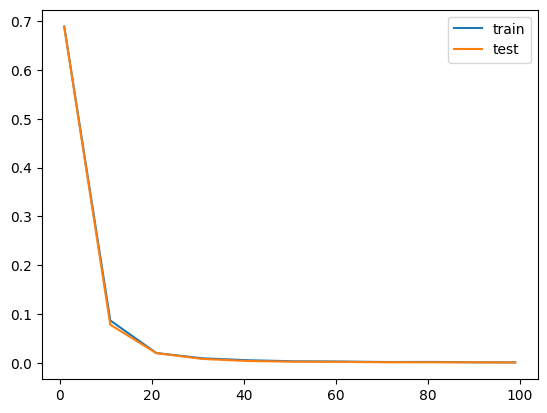

<Figure size 2000x2000 with 0 Axes>

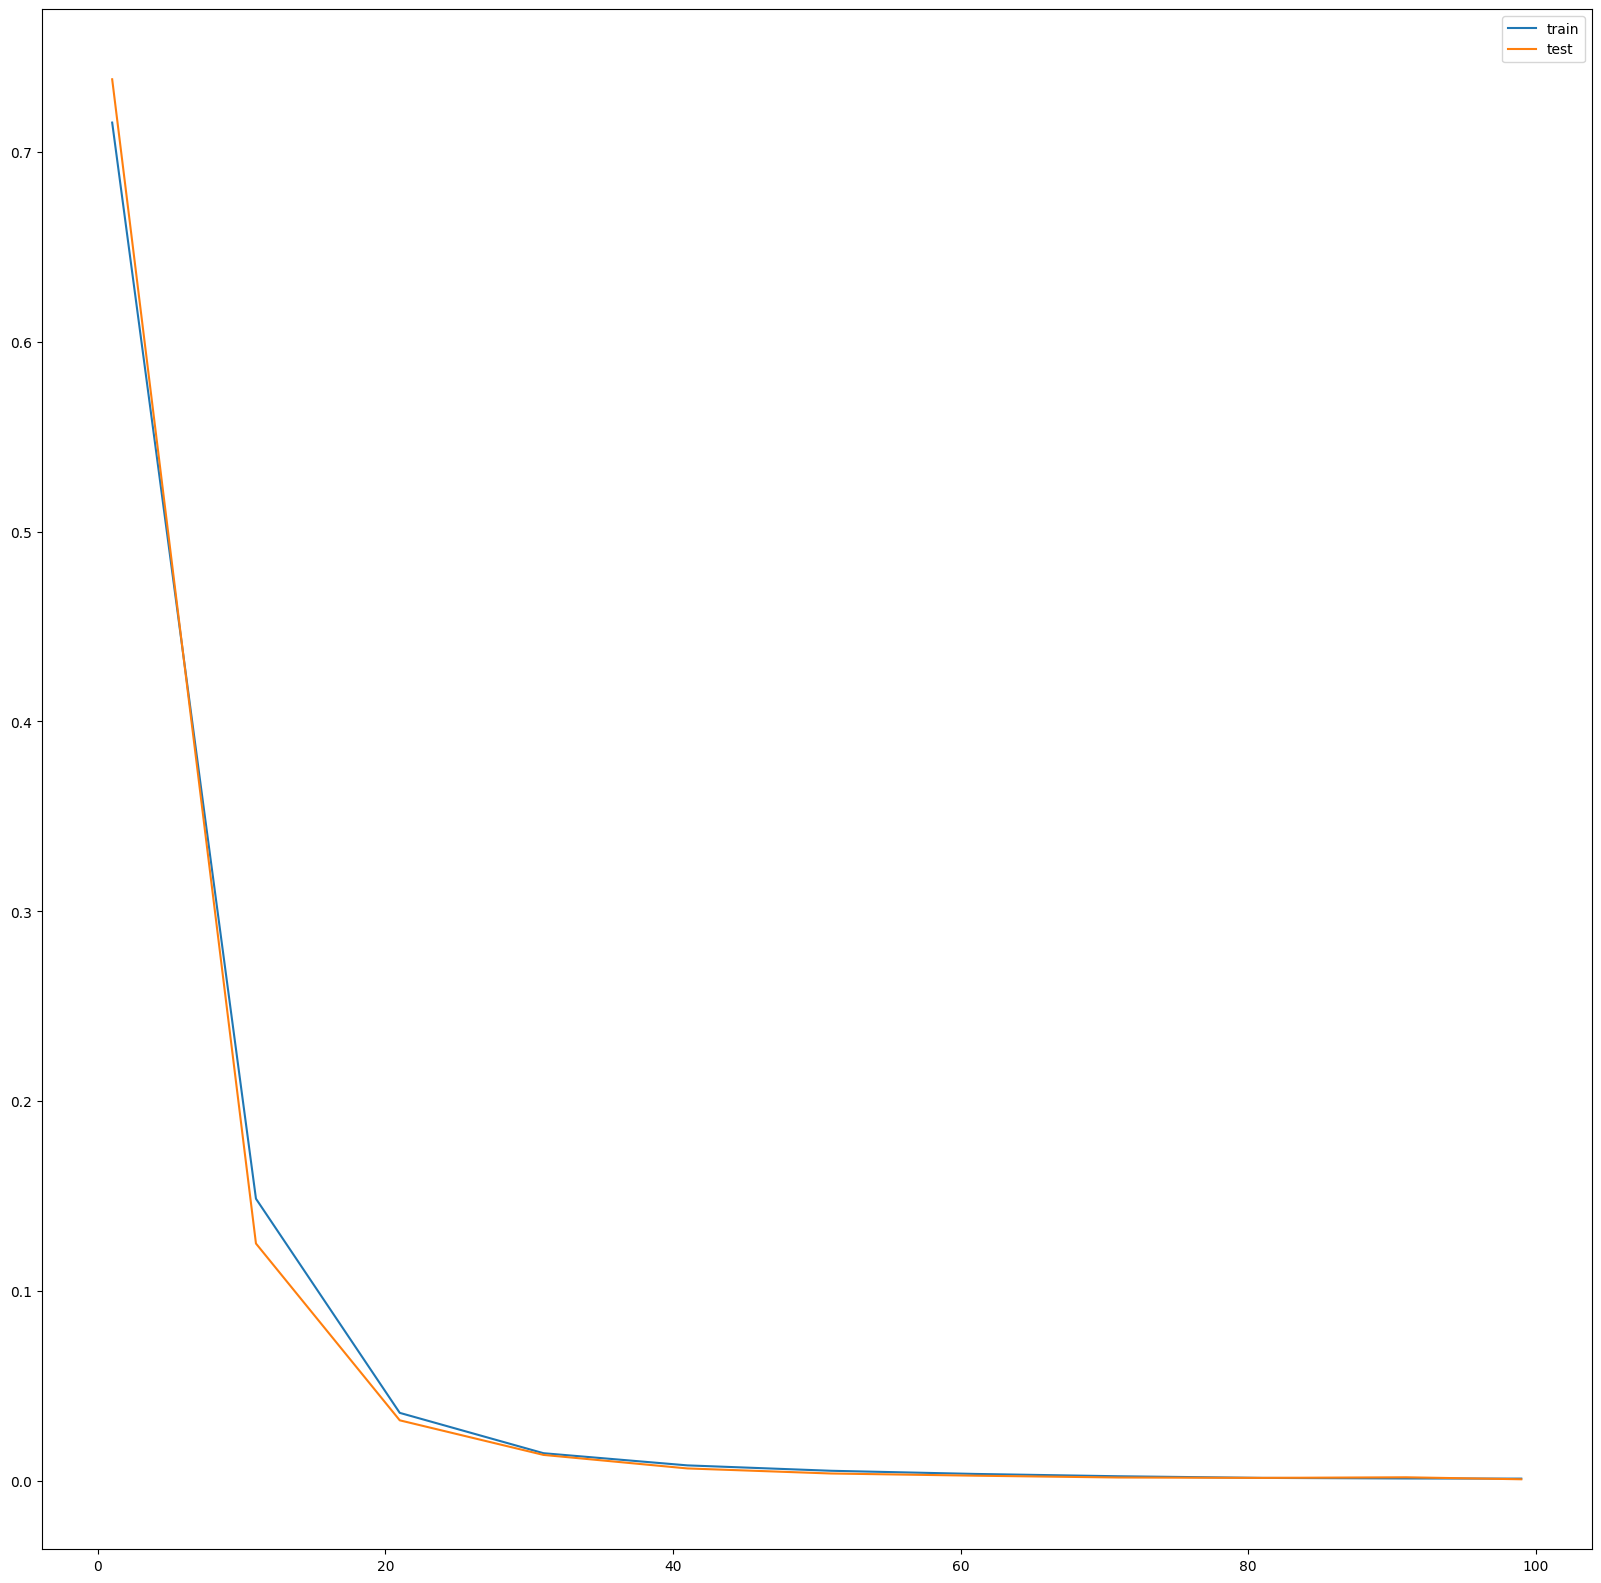

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

Error in callback <function _WandbInit._pause_backend at 0x7c15c4e2e290> (for post_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored

In [ ]:
start_with_wandb()
start_with_wandb(set_baseline_true=True)


In [ ]:
#!rm *.pth

Error in callback <function _WandbInit._resume_backend at 0x7c15c4e2e170> (for pre_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7c15c4e2e290> (for post_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7c15c4e2e290> (for post_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored